In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [6]:
cwd = os.getcwd()
images_path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "images")

In [7]:
### Apply function to values in nested dictionary

def apply_recursive(obj, func):
    if isinstance(obj, dict):  # if dict, apply to each key
        return {k: apply_recursive(v, func) for k, v in obj.items()}
    elif isinstance(obj, list):  # if list, apply to each element
        return [apply_recursive(elem, func) for elem in obj]
    else:
        return func(obj)

def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict, level=-1):
    #print(values_dict)
    flat_dict = flatten_dict(values_dict)
    #print(flat_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    # df = df.unstack(level=level)
    # df.columns = df.columns.map("{0[1]}".format)
    return df

def load_to_multi_index(path):
    results_dict = np.load(path, allow_pickle=True) #.item()
    fixed_results_dict = results_dict # apply_recursive(results_dict, lambda df: df.iloc[0].to_dict())
    df = nested_dict_to_df(fixed_results_dict)
    df.index.names = ['Dataset','Segmentation', 'ML model', 'Background', 'Normalization', 'Perturb', 'Metric']
    df.columns = ['Result']
    return df

# debug
# results_dict['UWAVE']['infogain']['resNet']['average']['normalized']['normal_distribution']


def load_from_folder(path):
    filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
    df_list = []
    for filename in filenames:
        filepath = os.path.join(path, filename)
        df = load_to_multi_index(path=filepath)
        df_list.append(df)
    merged_df = pd.concat(df_list)
    return merged_df


In [8]:
cwd = os.getcwd()
path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "results", "interprettime_results")
df_first = load_from_folder(path=path)
df_first.head()

Result
Dataset Segmentation ML model   Background Normalization Perturb             Metric             
EOG     binSeg       miniRocket average    normalized    normal_distribution AUCSE_top  0.496721
                                                                             F_score    0.250907
                                                         global_mean         AUCSE_top  0.534784
                                                                             F_score    0.256512
                                                         local_mean          AUCSE_top  0.544627

In [9]:
path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "results", "aucdiff_results")
filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
df_list = []
for filename in filenames:
    filepath = os.path.join(path, filename)
    df_0 = pd.read_csv(filepath, index_col=0)
    df_list.append(df_0)
merged_df = pd.concat(df_list)
df_second = merged_df.set_index(['Dataset','Segmentation', 'ML model', 'Background', 'Normalization', 'Perturb', 'Metric'])
df_second.head()

Result
Dataset Segmentation ML model   Background Normalization Perturb   Metric                  
EOG     clasp        miniRocket average    default       insertion AUC_difference  0.080664
                                                         deletion  AUC_difference  0.061430
                                                         insertion AUC_difference  0.037608
                                                         deletion  AUC_difference  0.032819
                                           normalized    insertion AUC_difference  0.079614

In [10]:
df = pd.concat([df_first, df_second]).reset_index()

# QUICKFIX (Temporary)

columns_wo_result = list(df.columns)
columns_wo_result.remove("Result")
all_duplicate = df.duplicated(subset=columns_wo_result)
mean_idxs = df.duplicated(subset=columns_wo_result, keep='last')
std_idxs = df.duplicated(subset=columns_wo_result, keep='first')
df.loc[mean_idxs, "Perturb"] += "_mean"
df.loc[std_idxs, "Perturb"] += "_std"

In [11]:
df

Dataset Segmentation    ML model Background Normalization  \
0        EOG       binSeg  miniRocket    average    normalized   
1        EOG       binSeg  miniRocket    average    normalized   
2        EOG       binSeg  miniRocket    average    normalized   
3        EOG       binSeg  miniRocket    average    normalized   
4        EOG       binSeg  miniRocket    average    normalized   
...      ...          ...         ...        ...           ...   
8635   UWAVE     bottomUp      resNet       zero       default   
8636   UWAVE     bottomUp      resNet       zero    normalized   
8637   UWAVE     bottomUp      resNet       zero    normalized   
8638   UWAVE     bottomUp      resNet       zero    normalized   
8639   UWAVE     bottomUp      resNet       zero    normalized   

                  Perturb          Metric    Result  
0     normal_distribution       AUCSE_top  0.496721  
1     normal_distribution         F_score  0.250907  
2             global_mean       AUCSE_top  0.534784  
3             global_mean         F_score  0.256512  
4              local_mean       AUCSE_top  0.544627  
...                   ...             ...       ...  
8635         deletion_std  AUC_difference  0.130497  
8636       insertion_mean  AUC_difference  0.338062  
8637        deletion_mean  AUC_difference  0.136664  
8638        insertion_std  AUC_difference  0.174196  
8639         deletion_std  AUC_difference  0.135635  

[8640 rows x 8 columns]

## Index and column names

In [12]:
df.index

RangeIndex(start=0, stop=8640, step=1)

In [13]:
df.columns

Index(['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization',
       'Perturb', 'Metric', 'Result'],
      dtype='object')

## Masking

In [14]:
mask = (df["Metric"] == 'F_score') & (df["Result"] > 1)
df.loc[mask]

Empty DataFrame
Columns: [Dataset, Segmentation, ML model, Background, Normalization, Perturb, Metric, Result]
Index: []

In [15]:
mask = (df["Metric"] == 'F_score') & (df["Result"] < 0)
df.loc[mask]

Dataset    Segmentation    ML model Background Normalization  \
1153  gunpoint        bottomUp  miniRocket    average    normalized   
1159  gunpoint        bottomUp  miniRocket    average    normalized   
1161  gunpoint        bottomUp  miniRocket    average       default   
1163  gunpoint        bottomUp  miniRocket    average       default   
1167  gunpoint        bottomUp  miniRocket    average       default   
1173  gunpoint        bottomUp  miniRocket       zero    normalized   
1185  gunpoint          binSeg  miniRocket    average    normalized   
1191  gunpoint          binSeg  miniRocket    average    normalized   
1193  gunpoint          binSeg  miniRocket    average       default   
1199  gunpoint          binSeg  miniRocket    average       default   
1217  gunpoint       kernelCPD  miniRocket    average    normalized   
1223  gunpoint       kernelCPD  miniRocket    average    normalized   
1225  gunpoint       kernelCPD  miniRocket    average       default   
1227  gunpoint       kernelCPD  miniRocket    average       default   
1231  gunpoint       kernelCPD  miniRocket    average       default   
1249  gunpoint     windowBased  miniRocket    average    normalized   
1251  gunpoint     windowBased  miniRocket    average    normalized   
1255  gunpoint     windowBased  miniRocket    average    normalized   
1257  gunpoint     windowBased  miniRocket    average       default   
1259  gunpoint     windowBased  miniRocket    average       default   
1263  gunpoint     windowBased  miniRocket    average       default   
1269  gunpoint     windowBased  miniRocket       zero    normalized   
1277  gunpoint     windowBased  miniRocket       zero       default   
1281  gunpoint       nnsegment  miniRocket    average    normalized   
1283  gunpoint       nnsegment  miniRocket    average    normalized   
1287  gunpoint       nnsegment  miniRocket    average    normalized   
1289  gunpoint       nnsegment  miniRocket    average       default   
1291  gunpoint       nnsegment  miniRocket    average       default   
1295  gunpoint       nnsegment  miniRocket    average       default   
1313  gunpoint           equal  miniRocket    average    normalized   
1319  gunpoint           equal  miniRocket    average    normalized   
1321  gunpoint           equal  miniRocket    average       default   
1327  gunpoint           equal  miniRocket    average       default   
1345  gunpoint           clasp  miniRocket    average       default   
1351  gunpoint           clasp  miniRocket    average       default   
1353  gunpoint           clasp  miniRocket    average    normalized   
1359  gunpoint           clasp  miniRocket    average    normalized   
1377  gunpoint  greedygaussian  miniRocket    average       default   
1383  gunpoint  greedygaussian  miniRocket    average       default   
1385  gunpoint  greedygaussian  miniRocket    average    normalized   
1391  gunpoint  greedygaussian  miniRocket    average    normalized   
1409  gunpoint        infogain  miniRocket    average    normalized   
1415  gunpoint        infogain  miniRocket    average    normalized   
1417  gunpoint        infogain  miniRocket    average       default   
1419  gunpoint        infogain  miniRocket    average       default   
1423  gunpoint        infogain  miniRocket    average       default   

                  Perturb   Metric    Result  
1153  normal_distribution  F_score -0.077633  
1159      global_gaussian  F_score -0.077656  
1161  normal_distribution  F_score -0.072358  
1163          global_mean  F_score -0.001675  
1167      global_gaussian  F_score -0.072388  
1173           local_mean  F_score -0.002582  
1185  normal_distribution  F_score -0.077650  
1191      global_gaussian  F_score -0.077772  
1193  normal_distribution  F_score -0.072619  
1199      global_gaussian  F_score -0.072600  
1217  normal_distribution  F_score -0.078111  
1223      global_gaussian  F_score -0.078075  
1225  normal_distribution  F_score -0.073379  
1227       

In [16]:
mask = (df["Metric"] == 'AUC_difference') & (df["Dataset"] == 'KeplerLightCurves') & (df["ML model"] == 'miniRocket')
df.loc[mask]

Dataset Segmentation    ML model Background Normalization  \
6048  KeplerLightCurves        clasp  miniRocket    average       default   
6049  KeplerLightCurves        clasp  miniRocket    average       default   
6050  KeplerLightCurves        clasp  miniRocket    average       default   
6051  KeplerLightCurves        clasp  miniRocket    average       default   
6052  KeplerLightCurves        clasp  miniRocket    average    normalized   
...                 ...          ...         ...        ...           ...   
6187  KeplerLightCurves    kernelCPD  miniRocket       zero       default   
6188  KeplerLightCurves    kernelCPD  miniRocket       zero    normalized   
6189  KeplerLightCurves    kernelCPD  miniRocket       zero    normalized   
6190  KeplerLightCurves    kernelCPD  miniRocket       zero    normalized   
6191  KeplerLightCurves    kernelCPD  miniRocket       zero    normalized   

             Perturb          Metric    Result  
6048  insertion_mean  AUC_difference  0.218415  
6049   deletion_mean  AUC_difference  0.210476  
6050   insertion_std  AUC_difference  0.092925  
6051    deletion_std  AUC_difference  0.086397  
6052  insertion_mean  AUC_difference  0.222677  
...              ...             ...       ...  
6187    deletion_std  AUC_difference  0.087248  
6188  insertion_mean  AUC_difference  0.241533  
6189   deletion_mean  AUC_difference  0.207713  
6190   insertion_std  AUC_difference  0.113392  
6191    deletion_std  AUC_difference  0.079571  

[144 rows x 8 columns]

In [17]:
mask = (df["Metric"] == 'AUCSE_top') & (df["Result"] < 0)
df.loc[mask]

Dataset    Segmentation    ML model Background Normalization  \
1152  gunpoint        bottomUp  miniRocket    average    normalized   
1154  gunpoint        bottomUp  miniRocket    average    normalized   
1158  gunpoint        bottomUp  miniRocket    average    normalized   
1160  gunpoint        bottomUp  miniRocket    average       default   
1162  gunpoint        bottomUp  miniRocket    average       default   
1166  gunpoint        bottomUp  miniRocket    average       default   
1184  gunpoint          binSeg  miniRocket    average    normalized   
1186  gunpoint          binSeg  miniRocket    average    normalized   
1190  gunpoint          binSeg  miniRocket    average    normalized   
1192  gunpoint          binSeg  miniRocket    average       default   
1194  gunpoint          binSeg  miniRocket    average       default   
1198  gunpoint          binSeg  miniRocket    average       default   
1216  gunpoint       kernelCPD  miniRocket    average    normalized   
1218  gunpoint       kernelCPD  miniRocket    average    normalized   
1222  gunpoint       kernelCPD  miniRocket    average    normalized   
1224  gunpoint       kernelCPD  miniRocket    average       default   
1226  gunpoint       kernelCPD  miniRocket    average       default   
1230  gunpoint       kernelCPD  miniRocket    average       default   
1248  gunpoint     windowBased  miniRocket    average    normalized   
1250  gunpoint     windowBased  miniRocket    average    normalized   
1254  gunpoint     windowBased  miniRocket    average    normalized   
1256  gunpoint     windowBased  miniRocket    average       default   
1258  gunpoint     windowBased  miniRocket    average       default   
1262  gunpoint     windowBased  miniRocket    average       default   
1268  gunpoint     windowBased  miniRocket       zero    normalized   
1276  gunpoint     windowBased  miniRocket       zero       default   
1280  gunpoint       nnsegment  miniRocket    average    normalized   
1282  gunpoint       nnsegment  miniRocket    average    normalized   
1286  gunpoint       nnsegment  miniRocket    average    normalized   
1288  gunpoint       nnsegment  miniRocket    average       default   
1290  gunpoint       nnsegment  miniRocket    average       default   
1294  gunpoint       nnsegment  miniRocket    average       default   
1300  gunpoint       nnsegment  miniRocket       zero    normalized   
1308  gunpoint       nnsegment  miniRocket       zero       default   
1312  gunpoint           equal  miniRocket    average    normalized   
1314  gunpoint           equal  miniRocket    average    normalized   
1318  gunpoint           equal  miniRocket    average    normalized   
1320  gunpoint           equal  miniRocket    average       default   
1322  gunpoint           equal  miniRocket    average       default   
1326  gunpoint           equal  miniRocket    average       default   
1344  gunpoint           clasp  miniRocket    average       default   
1350  gunpoint           clasp  miniRocket    average       default   
1352  gunpoint           clasp  miniRocket    average    normalized   
1358  gunpoint           clasp  miniRocket    average    normalized   
1376  gunpoint  greedygaussian  miniRocket    average       default   
1378  gunpoint  greedygaussian  miniRocket    average       default   
1382  gunpoint  greedygaussian  miniRocket    average       default   
1384  gunpoint  greedygaussian  miniRocket    average    normalized   
1386  gunpoint  greedygaussian  miniRocket    average    normalized   
1390  gunpoint  greedygaussian  miniRocket    average    normalized   
1408  gunpoint        infogain  miniRocket    average    normalized   
1410  gunpoint        infogain  miniRocket    average    normalized   
1414  gunpoint        infogain  miniRocket    average    normalized   
1416  gunpoint        infogain  miniRocket    average       default   
1418  gunpoint        infogain  miniRocket    average       default   
1422  gunpoint        infogain 

In [18]:
mask = (df["Metric"] == 'AUC_difference') & (df["Result"].isna())
df.loc[mask].head()

Empty DataFrame
Columns: [Dataset, Segmentation, ML model, Background, Normalization, Perturb, Metric, Result]
Index: []

In [19]:
mask = (df["Metric"] == 'AUC_difference') & (df["Result"] < 0)
df.loc[mask].head()

Empty DataFrame
Columns: [Dataset, Segmentation, ML model, Background, Normalization, Perturb, Metric, Result]
Index: []

# Data Analysis

## Correlation matrix

In [20]:
mask = (df["Metric"]=='AUCSE_top')
df2 = df.loc[mask] # , ['Perturb', "Result"]
df2 = df2.pivot(index = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric'], columns='Perturb', values="Result")
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

In [21]:
mask = (df["Metric"]=='F_score')
df2 = df.loc[mask] # , ['Perturb', "Result"]
df2 = df2.pivot(index = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric'], columns='Perturb', values="Result")
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

In [22]:
# df2 = df.unstack(["Metric"])
# df2.columns = df2.columns.droplevel(0)
# corr = df2.corr()
# coef_det = corr ** 2
# coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

### AUCSE_top
#### local_mean vs global_mean

In [23]:
df.columns

Index(['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization',
       'Perturb', 'Metric', 'Result'],
      dtype='object')

In [24]:
columns_wo_result = list(df.columns)
columns_wo_result.remove("Result")

In [25]:
columns_wo_result

['Dataset',
 'Segmentation',
 'ML model',
 'Background',
 'Normalization',
 'Perturb',
 'Metric']

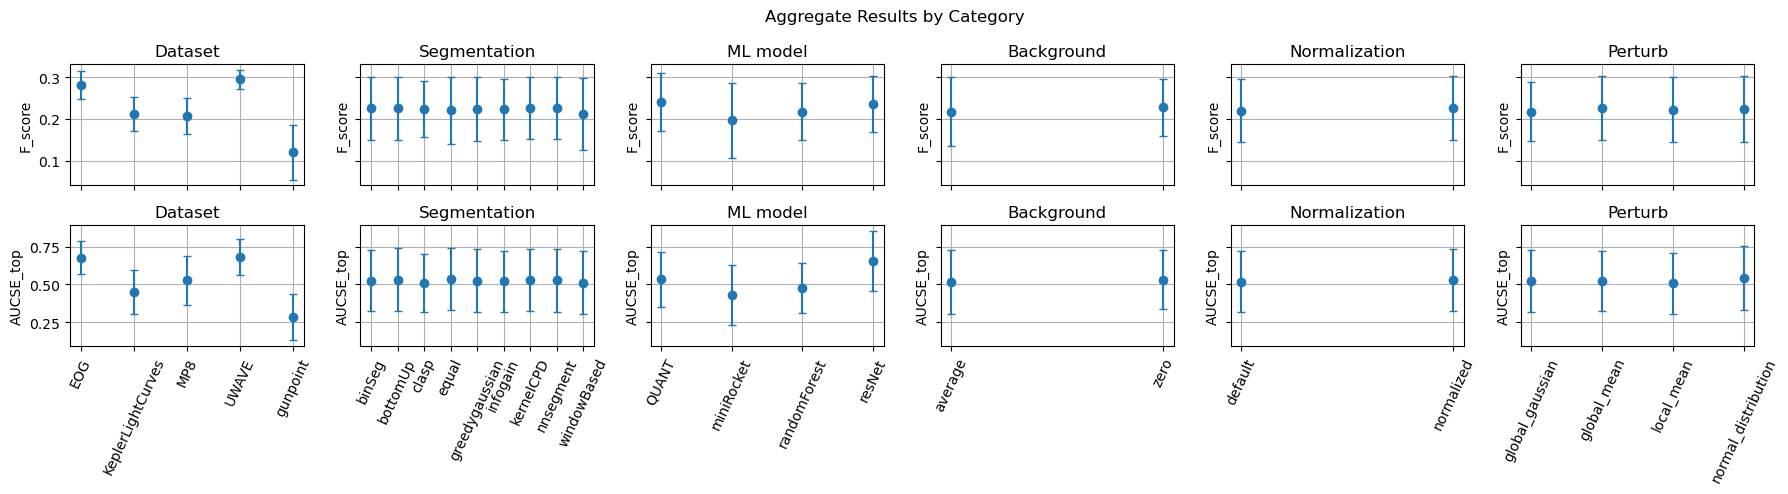

In [26]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
metric_names = ['F_score', 'AUCSE_top']

fig, ax = plt.subplots(len(metric_names), len(active_columns), figsize = (18,5), sharex="col", sharey="row")

for j, metric_name in enumerate(metric_names):

    mask = (df["Metric"]==metric_name)
    df2 = df.loc[mask] # , ['Perturb', "Result"]
    #ax[j].set_title(metric_name)

    for i, column_name in enumerate(active_columns):
        df3 = df2.groupby([column_name]).agg({'Result': ["mean", "std"]})
        df3_mean = df3[("Result", "mean")]
        df3_std = df3[("Result", "std")]
        
        ax[j, i].errorbar(df3.index, df3_mean.values, df3_std, linestyle='None', marker='o', capsize=3)
        ax[j, i].grid()
        ax[j, i].tick_params("x", rotation=65)
        ax[j, i].set_title(column_name)
        ax[j, i].set_ylabel(metric_name)

for axis, metric_name in zip(ax[:, 0], metric_names):
    axis.set_ylabel(metric_name)

fig.suptitle("Aggregate Results by Category")
fig.tight_layout()

In [27]:
# mask = (df["Metric"]=="AUC_difference")
# df2 = df.loc[mask]
# df2.head()

# # Pivot the table to have metrics as columns
# pivoted = df2.pivot(index=["Dataset",	"Segmentation",	"ML model",	"Background",	"Normalization", "Metric"	], columns='Perturb', values='Result').reset_index()

# # Calculate the difference metric
# pivoted['aucdiff'] = pivoted["insertion_mean"] - pivoted["deletion_mean"]

# # Optional: Melt back to long format if needed
# df3 = pivoted.melt(id_vars=["Dataset",	"Segmentation",	"ML model",	"Background",	"Normalization", "Metric"], 
#                       value_vars=["insertion_mean", "deletion_mean", 'aucdiff'],
#                       var_name="Metric",
#                       value_name='Result')


# df3.head()

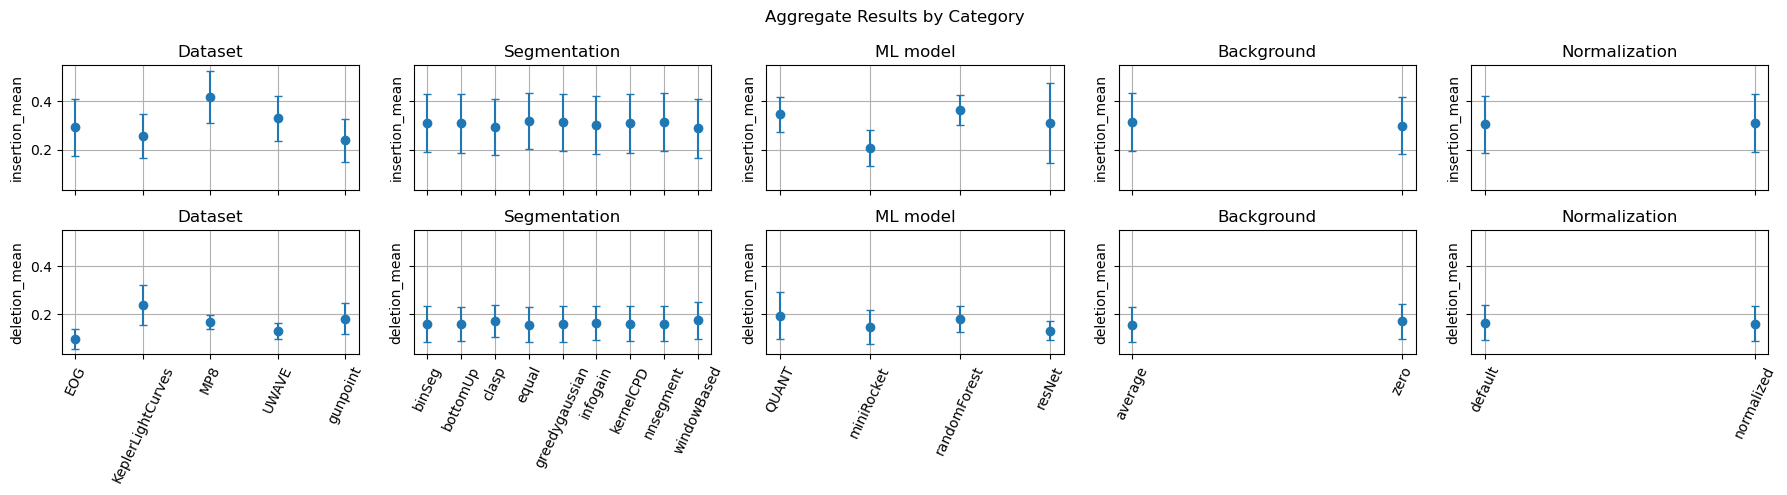

In [28]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Perturb")





perturb_names = ["insertion_mean", "deletion_mean"]

fig, ax = plt.subplots(len(perturb_names), len(active_columns), figsize = (18, 5), sharex="col", sharey=True)

for j, perturb_name in enumerate(perturb_names):

    mask = (df["Metric"]=="AUC_difference") & (df["Perturb"]==perturb_name)
    df2 = df.loc[mask]

    for i, column_name in enumerate(active_columns):
        df3 = df2.groupby([column_name]).agg({'Result': ["mean", "std"]})
        df3.columns = df3.columns.get_level_values(1)
        df3_mean = df3["mean"]
        df3_std = df3["std"]
        
        ax[j, i].errorbar(df3.index, df3_mean.values, df3_std, linestyle='None', marker='o', capsize=3)
        ax[j, i].grid()
        ax[j, i].tick_params("x", rotation=65)
        ax[j, i].set_title(column_name)
        ax[j, i].set_ylabel(perturb_name)


for axis, perturb_name in zip(ax[:, 0], perturb_names):
    axis.set_ylabel(perturb_name)

fig.suptitle("Aggregate Results by Category")
fig.tight_layout()

In [29]:
from itertools import combinations

In [30]:
# for col in df2[active_columns]:
#     print(col)
#     print(len(df2[col].unique()))

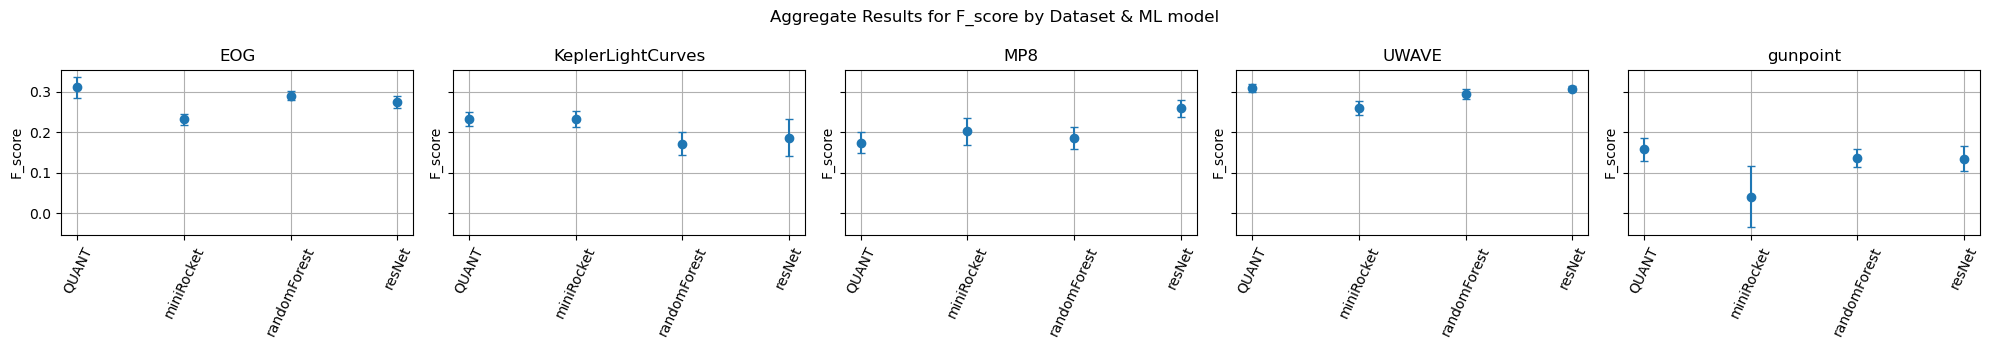

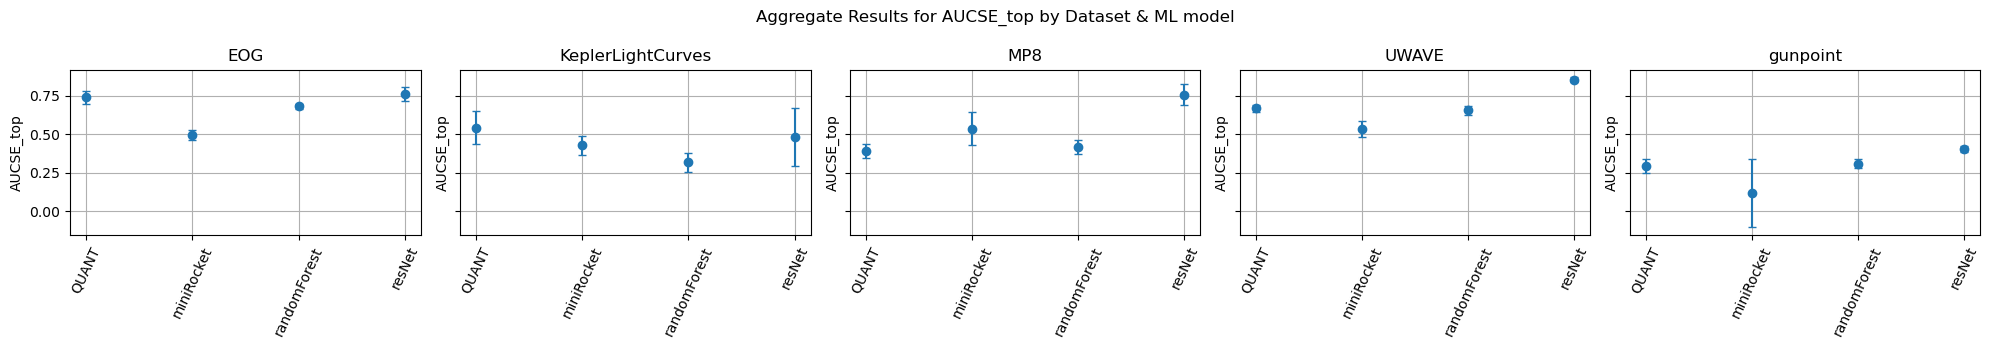

In [31]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_combinations = [["Dataset", "ML model"]] #list(combinations(active_columns, 2))  #
metric_names = ["F_score", 'AUCSE_top']

for metric_name in metric_names:

    mask = (df["Metric"]==metric_name) & (df["Normalization"]=="default")
    df2 = df.loc[mask] # , ['Perturb', "Result"]
    # col_unique_lengths = []
    # for col in df2[active_columns]:
    #     col_unique_lengths.append(len(df2[col].unique()))
    # n_rows = len(active_combinations)
    # max_cols = np.max(col_unique_lengths)

    for column_names in active_combinations:
        df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
        index_levels = df3.index.levels
        df3.columns = df3.columns.get_level_values(1)
        df3 = df3.reset_index()

        n_cols = len(index_levels[0])

        fig, ax = plt.subplots(1, n_cols, figsize = (4*n_cols, 3.5), sharex=True, sharey=True) #dpi

        for j, column_name in enumerate(index_levels[0]):
            mask4 = df3[column_names[0]]==column_name
            df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
            df4 = df4.set_index(column_names[1])

            df4_mean = df4["mean"]
            df4_std = df4["std"]
            
            ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
            ax[j].grid()
            ax[j].tick_params("x", rotation=65)
            ax[j].set_title(column_name)
            ax[j].set_ylabel(metric_name)

            fig_name = f"Aggregate Results for {metric_name} by {column_names[0]} & {column_names[1]}"
            fig.suptitle(fig_name)
            fig.tight_layout()
            fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100


In [32]:
# perturbations matter on Kepler
# gunpoint minirocket
# kepler resnet

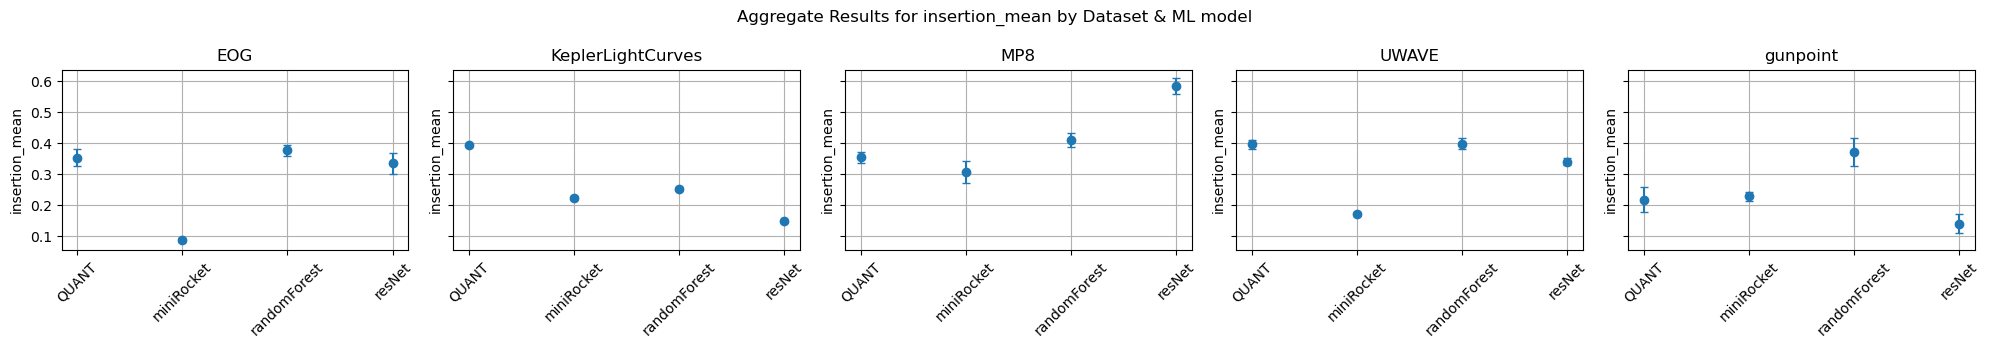

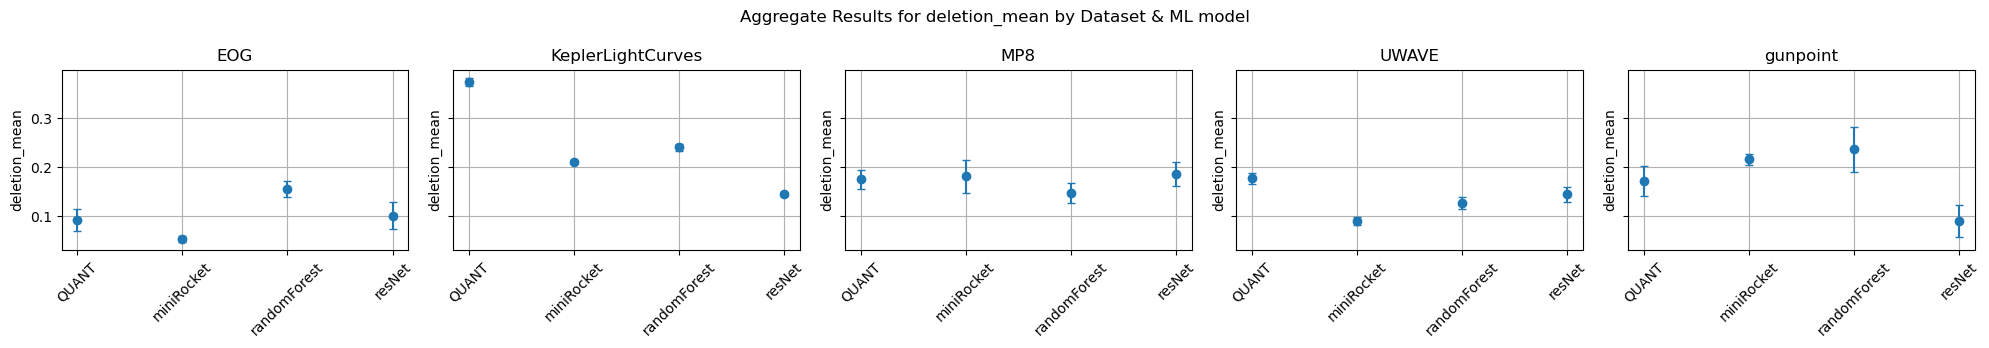

In [33]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Perturb")
active_combinations = [["Dataset", "ML model"]] #list(combinations(active_columns, 2)) # 
perturb_names = ["insertion_mean", "deletion_mean"]

for perturb_name in perturb_names:

    mask = (df["Metric"]=="AUC_difference") & (df["Perturb"]==perturb_name) & (df["Normalization"]=="default")
    df2 = df.loc[mask] # , ['Perturb', "Result"]

    for column_names in active_combinations:
        df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
        index_levels = df3.index.levels
        df3.columns = df3.columns.get_level_values(1)
        df3 = df3.reset_index()

        n_cols = len(index_levels[0])

        fig, ax = plt.subplots(1, n_cols, figsize = (4*n_cols, 3.5), sharex=True, sharey=True) #dpi

        for j, column_name in enumerate(index_levels[0]):
            mask4 = df3[column_names[0]]==column_name
            df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
            df4 = df4.set_index(column_names[1])

            df4_mean = df4["mean"]
            df4_std = df4["std"]
            
            ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
            ax[j].grid()
            ax[j].tick_params("x", rotation=45)
            ax[j].set_title(column_name)
            ax[j].set_ylabel(perturb_name)

            fig_name = f"Aggregate Results for {perturb_name} by {column_names[0]} & {column_names[1]}"
            fig.suptitle(fig_name)
            fig.tight_layout()
            fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100

In [29]:
# sampling on resnet more consistent on auc deletion
# clasp worse on EOG pn both
# zero background worse on MP8

In [30]:
# fig.savefig('test2png.png', dpi=100)
# To propagate the size change to an existing GUI window, add forward=True:

# fig.set_size_inches(18.5, 10.5, forward=True)
# Additionally as Erik Shilts mentioned in the comments you can also use figure.set_dpi to "[s]et the resolution of the figure in dots-per-inch"

# fig.set_dpi(100)

In [33]:
# temp = df2.groupby([column_name]).agg({'Result': ["mean", "std"]})
# temp.columns = [' '.join(col).strip() for col in temp.columns.values]
# temp

#minor modification to maintain underscore for joined cols only: ['_'.join(col).rstrip('_') for col in df.columns.values]

#df.columns = df.columns.to_flat_index().str.join('_')

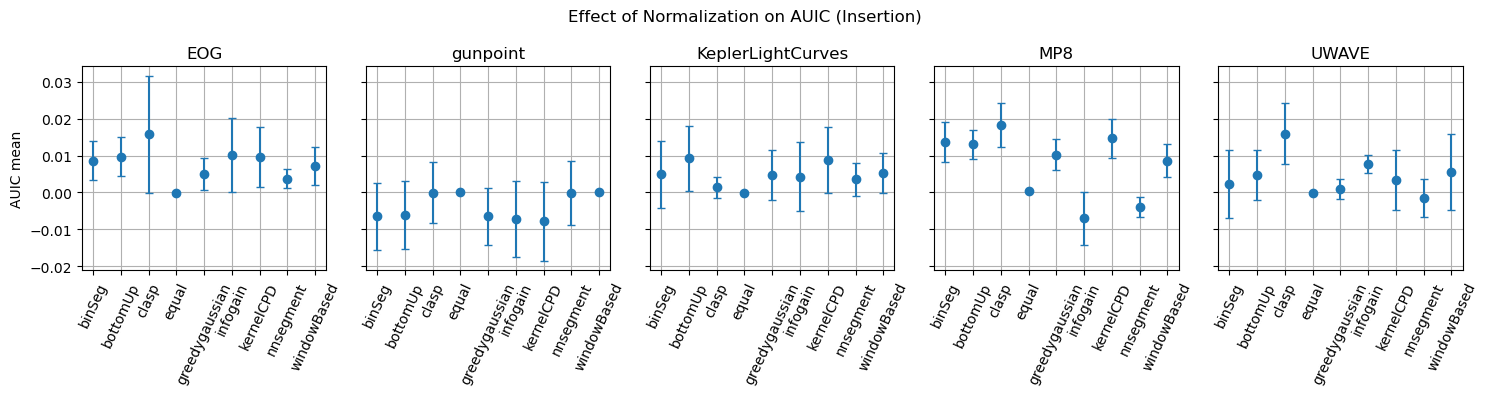

In [46]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="AUC_difference") & (df["Perturb"]=="insertion_mean")# , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask]
active_columns = columns_wo_result.copy()
active_columns.remove('Normalization')
pivoted = df2.pivot(index=active_columns, columns='Normalization', values='Result').reset_index()
pivoted['DIFF'] = pivoted['normalized'] - pivoted['default']

# result = pivoted.melt(id_vars=['dataset', 'id'], 
#                       value_vars=['metric1', 'metric2', 'metric_diff'],
#                       var_name='metric_type',
#                       value_name='value')

df3 = pivoted.groupby(["Dataset", "Segmentation"]).agg({'DIFF': ["mean", "std"]}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask_dataset = (df3["Dataset"]==dataset_name)
    df4 = df3.loc[mask_dataset, ["Segmentation", 'DIFF']]

    x = df4["Segmentation"].values
    means = df4[("DIFF", "mean")].values
    stds = df4[("DIFF", "std")].values


    ax[i].set_title(dataset_name)
    ax[i].errorbar(x, means, stds, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=65)

ax[0].set_ylabel("AUIC mean")

fig.suptitle("Effect of Normalization on AUIC (Insertion)")
fig.tight_layout()

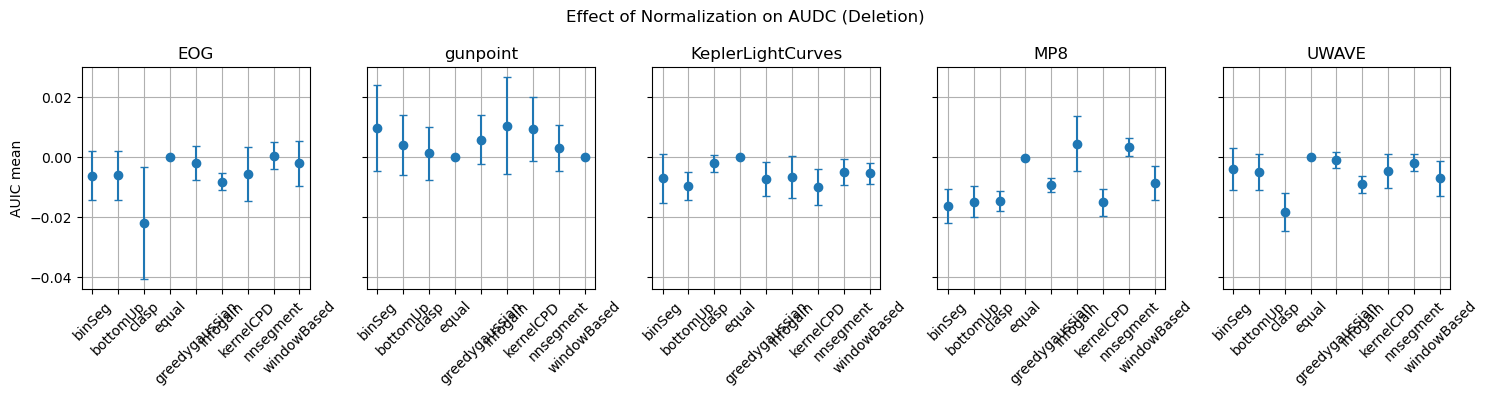

In [45]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="AUC_difference") & (df["Perturb"]=="deletion_mean")# , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask]
active_columns = columns_wo_result.copy()
active_columns.remove('Normalization')
pivoted = df2.pivot(index=active_columns, columns='Normalization', values='Result').reset_index()
pivoted['DIFF'] = pivoted['normalized'] - pivoted['default']

df3 = pivoted.groupby(["Dataset", "Segmentation"]).agg({'DIFF': ["mean", "std"]}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask_dataset = (df3["Dataset"]==dataset_name)
    df4 = df3.loc[mask_dataset, ["Segmentation", 'DIFF']]

    x = df4["Segmentation"].values
    means = df4[("DIFF", "mean")].values
    stds = df4[("DIFF", "std")].values


    ax[i].set_title(dataset_name)
    ax[i].errorbar(x, means, stds, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=65)

ax[0].set_ylabel("AUIC mean")

fig.suptitle("Effect of Normalization on AUDC (Deletion)")
fig.tight_layout()

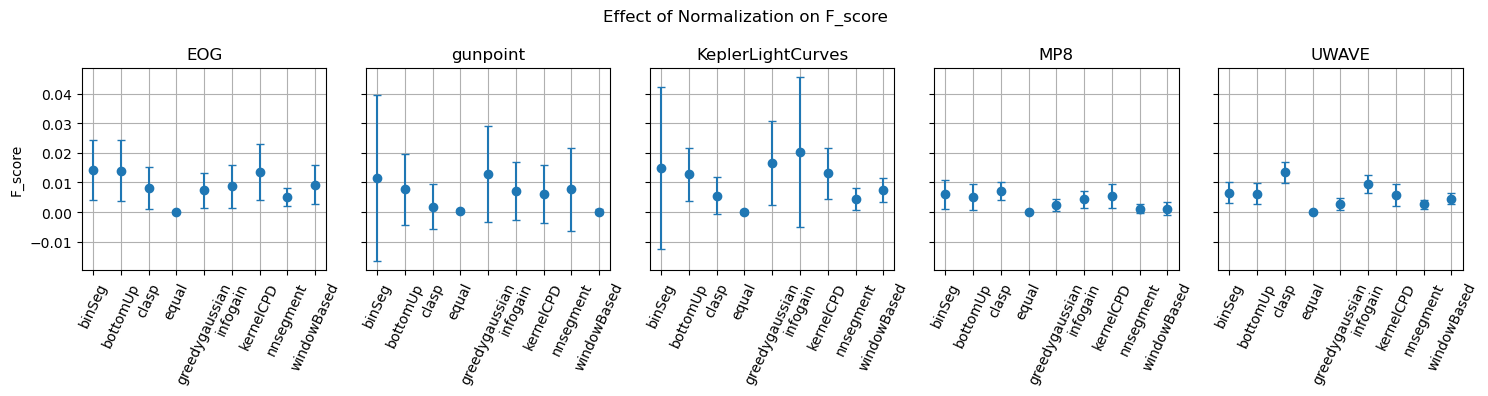

In [48]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="F_score") # , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask]
active_columns = columns_wo_result.copy()
active_columns.remove('Normalization')
pivoted = df2.pivot(index=active_columns, columns='Normalization', values='Result').reset_index()
pivoted['DIFF'] = pivoted['normalized'] - pivoted['default']


df3 = pivoted.groupby(["Dataset", "Segmentation"]).agg({'DIFF': ["mean", "std"]}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask_dataset = (df3["Dataset"]==dataset_name)
    df4 = df3.loc[mask_dataset, ["Segmentation", 'DIFF']]

    x = df4["Segmentation"].values
    means = df4[("DIFF", "mean")].values
    stds = df4[("DIFF", "std")].values


    ax[i].set_title(dataset_name)
    ax[i].errorbar(x, means, stds, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=65)

ax[0].set_ylabel("F_score")

fig.suptitle("Effect of Normalization on F_score")
fig.tight_layout()

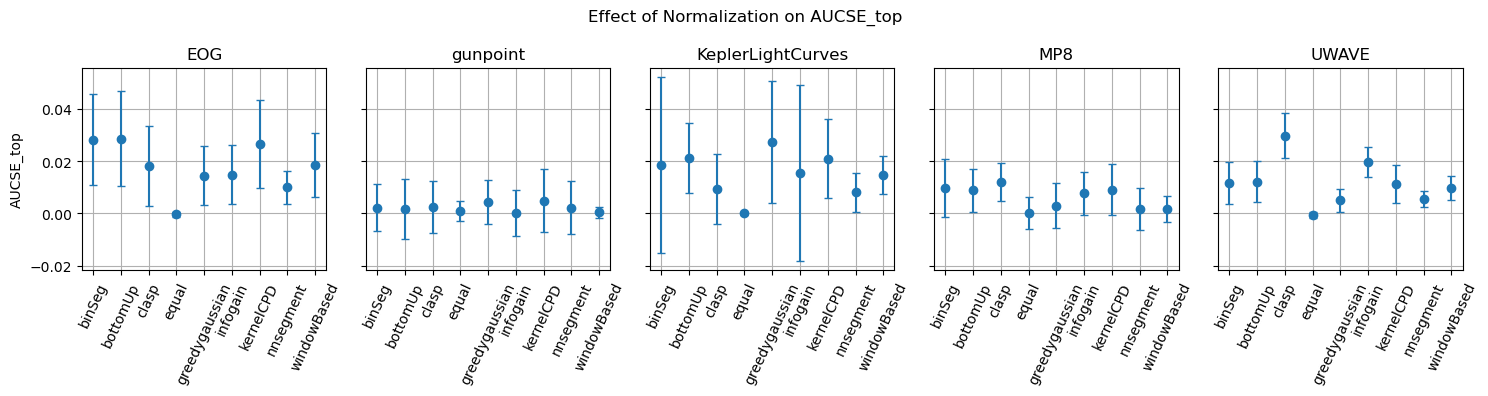

In [49]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=='AUCSE_top') # , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask]
active_columns = columns_wo_result.copy()
active_columns.remove('Normalization')
pivoted = df2.pivot(index=active_columns, columns='Normalization', values='Result').reset_index()
pivoted['DIFF'] = pivoted['normalized'] - pivoted['default']


df3 = pivoted.groupby(["Dataset", "Segmentation"]).agg({'DIFF': ["mean", "std"]}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask_dataset = (df3["Dataset"]==dataset_name)
    df4 = df3.loc[mask_dataset, ["Segmentation", 'DIFF']]

    x = df4["Segmentation"].values
    means = df4[("DIFF", "mean")].values
    stds = df4[("DIFF", "std")].values


    ax[i].set_title(dataset_name)
    ax[i].errorbar(x, means, stds, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=65)

ax[0].set_ylabel("AUCSE_top")

fig.suptitle("Effect of Normalization on AUCSE_top")
fig.tight_layout()

In [ ]:
0/0

In [42]:
from itertools import combinations

In [44]:
pairs_of_interest = [("KeplerLightCurves", "resNet"), ("gunpoint", "miniRocket"), ("MP8", "miniRocket")]

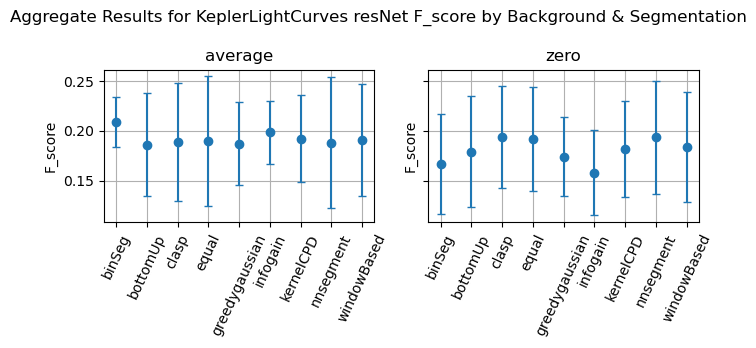

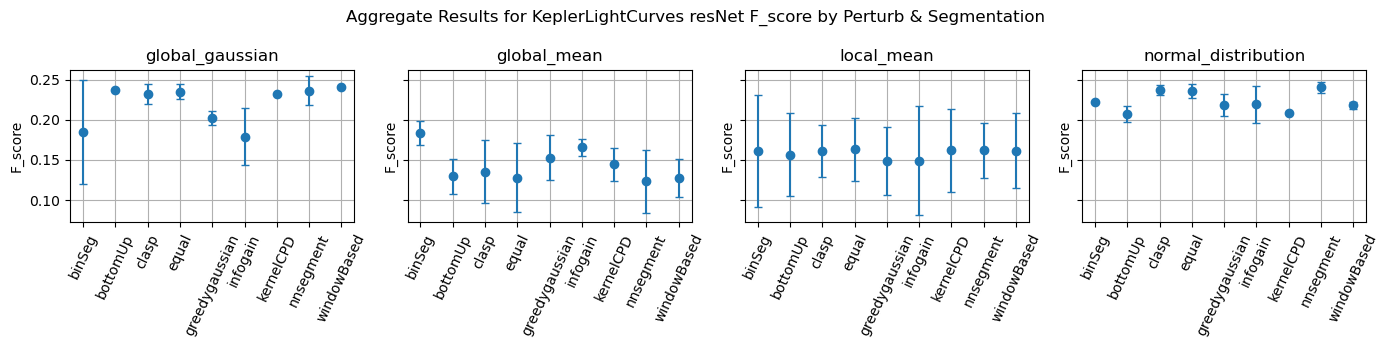

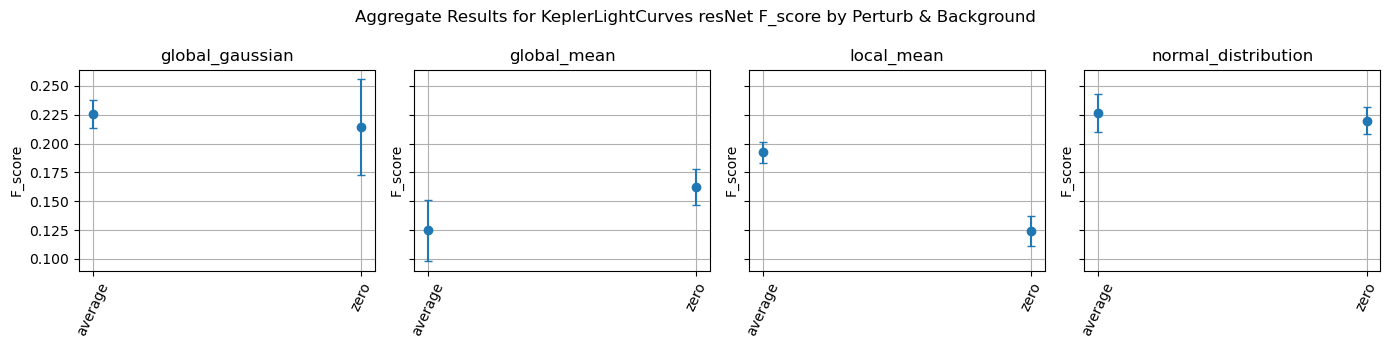

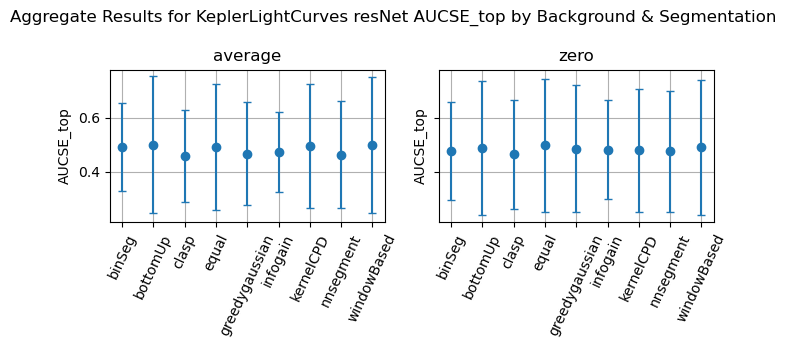

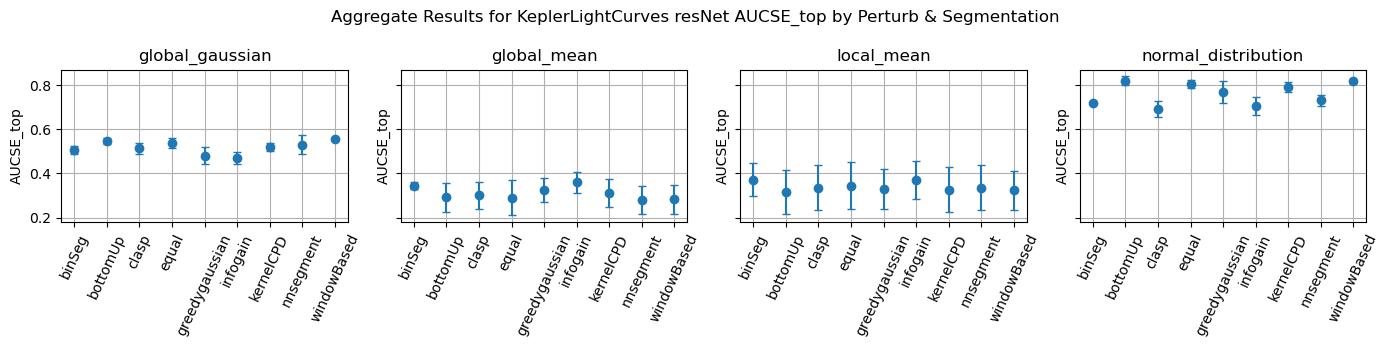

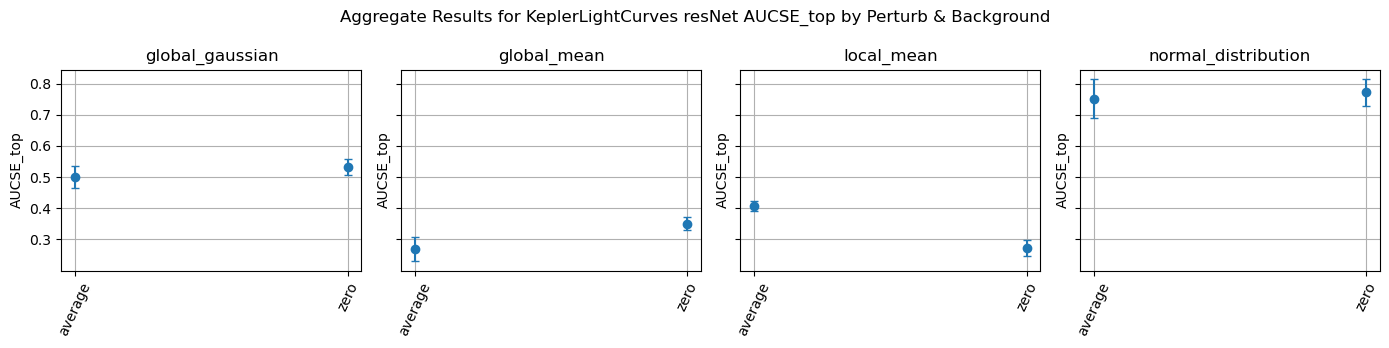

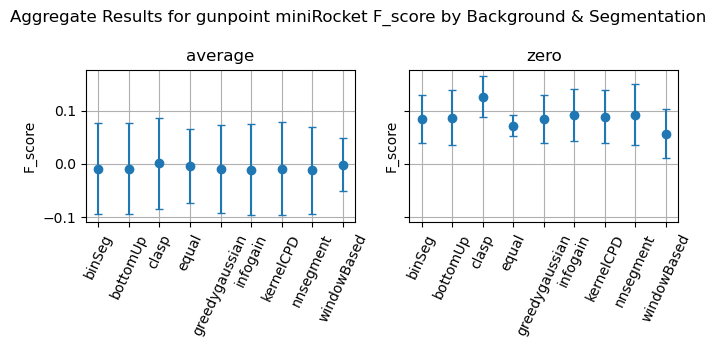

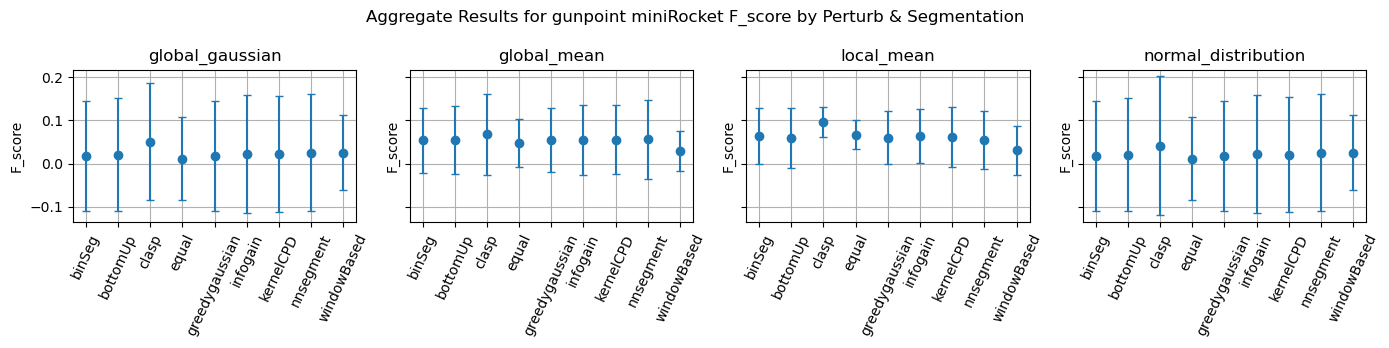

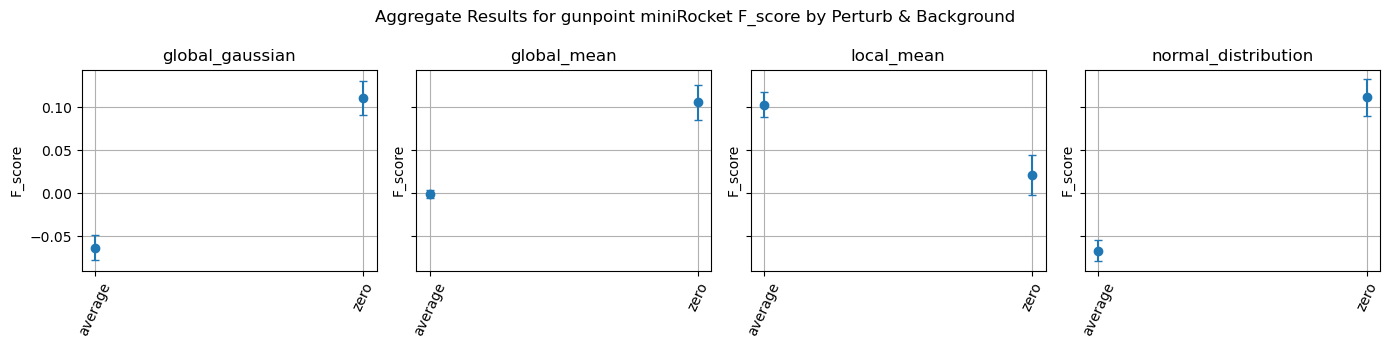

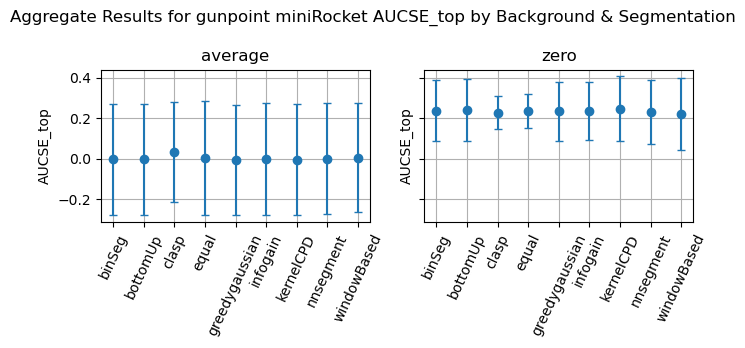

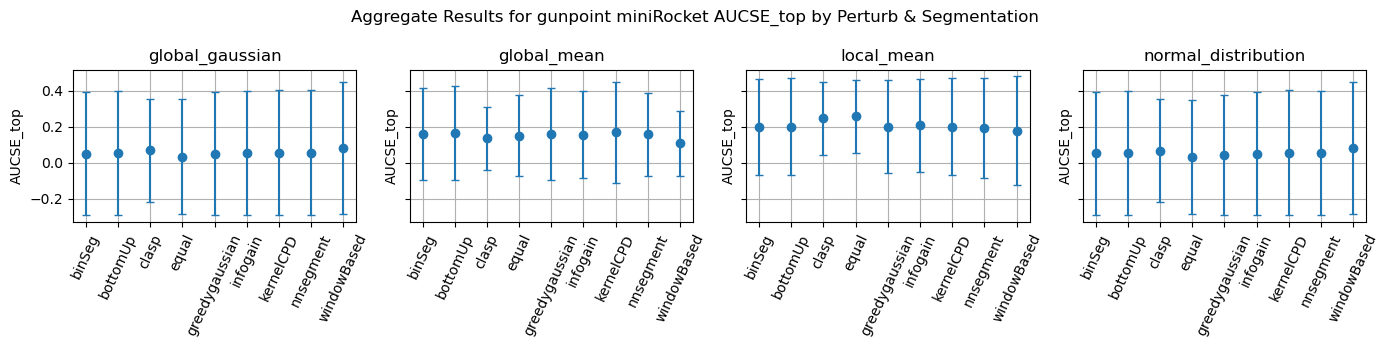

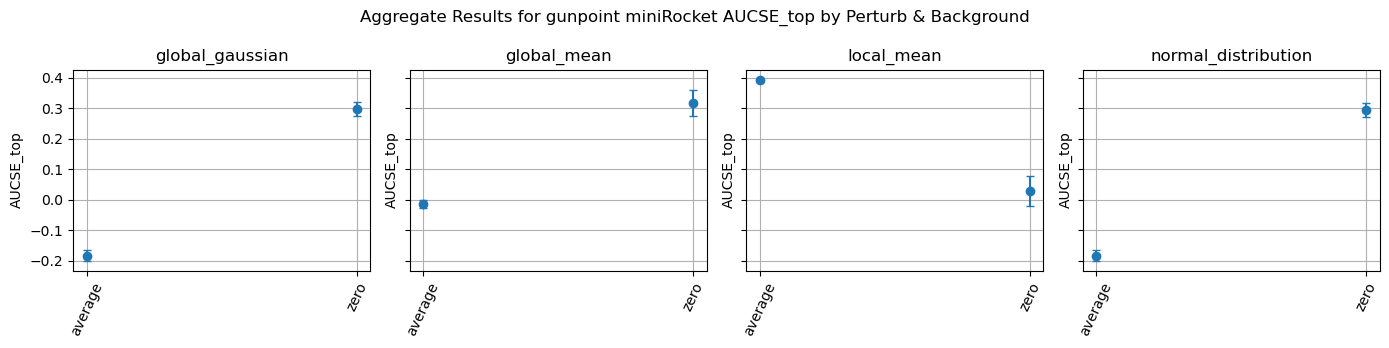

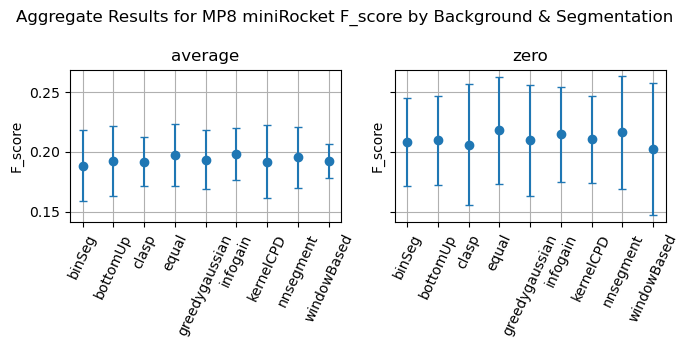

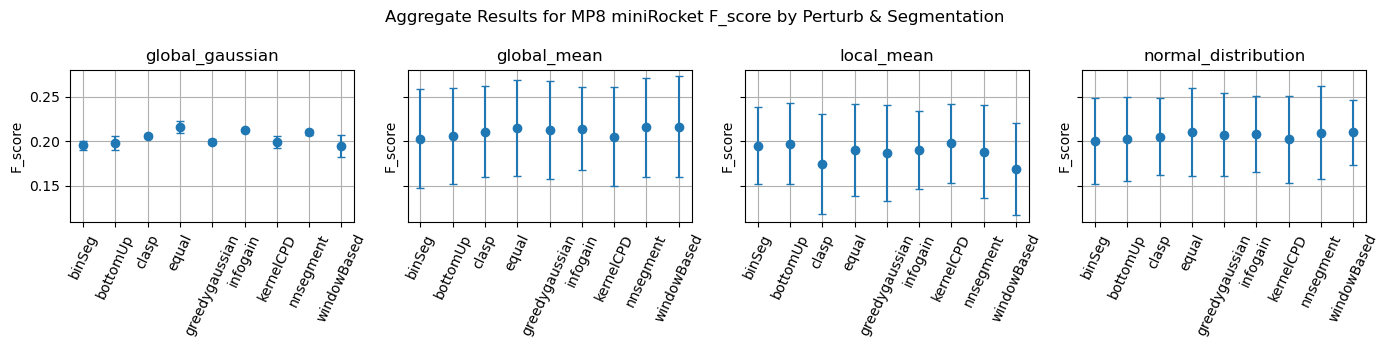

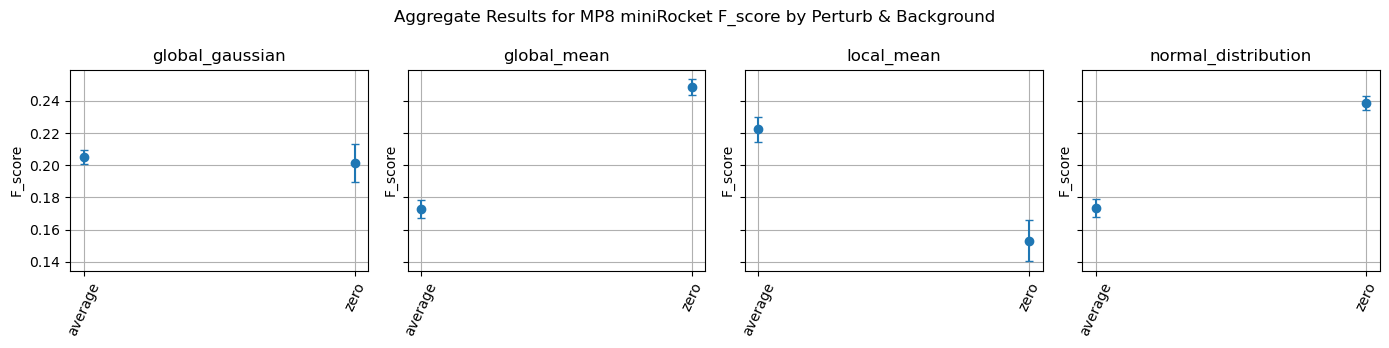

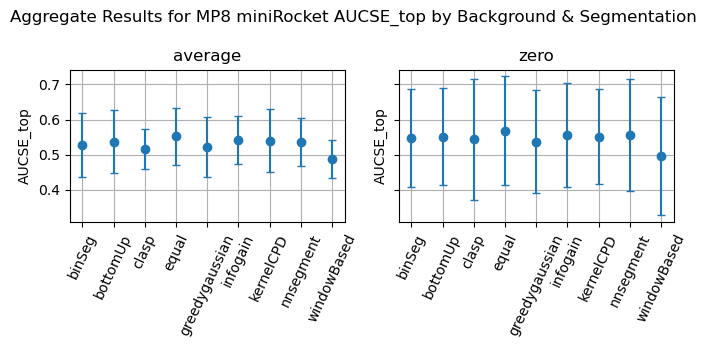

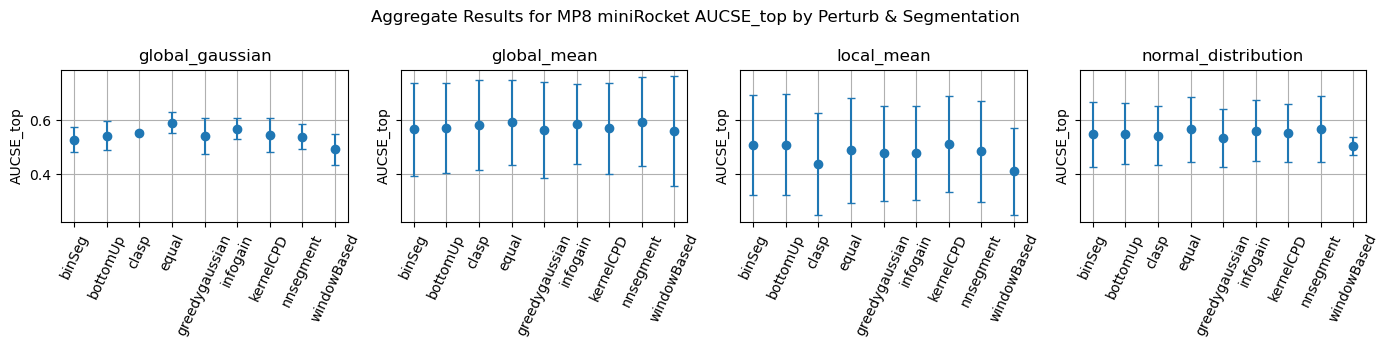

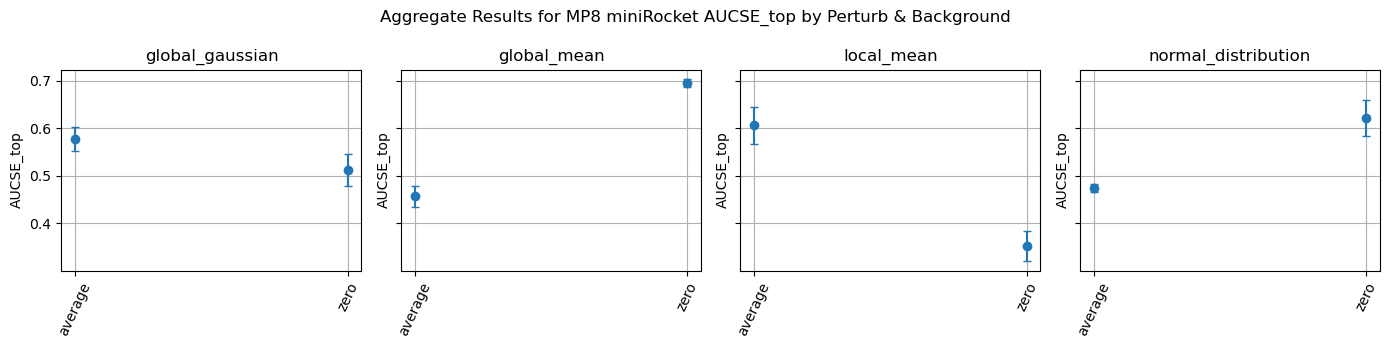

In [45]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Dataset")
active_columns.remove("ML model")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_names = ["F_score", 'AUCSE_top']

for pair_of_interest in pairs_of_interest:
    dataset_name, ml_model_name = pair_of_interest

    for metric_name in metric_names:

        mask = (df["Metric"]==metric_name) & (df["Normalization"]=="default") & (df["Dataset"]==dataset_name) & (df["ML model"]==ml_model_name)
        df2 = df.loc[mask] # , ['Perturb', "Result"]
        # col_unique_lengths = []
        # for col in df2[active_columns]:
        #     col_unique_lengths.append(len(df2[col].unique()))
        # n_rows = len(active_combinations)
        # max_cols = np.max(col_unique_lengths)

        for column_names in active_combinations:
            column_names = column_names[::-1]
            df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
            index_levels = df3.index.levels
            df3.columns = df3.columns.get_level_values(1)
            df3 = df3.reset_index()
            # print(dataset_name, ml_model_name, metric_name, column_names[0], column_names[1])
            # print(index_levels)

            n_cols = len(index_levels[0])

            fig, ax = plt.subplots(1, n_cols, figsize = (3.5*n_cols, 3.5), sharex=True, sharey=True) #dpi

            for j, column_name in enumerate(index_levels[0]):
                mask4 = df3[column_names[0]]==column_name
                df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
                df4 = df4.set_index(column_names[1])

                df4_mean = df4["mean"]
                df4_std = df4["std"]
                
                ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
                ax[j].grid()
                ax[j].tick_params("x", rotation=65)
                ax[j].set_title(column_name)
                ax[j].set_ylabel(metric_name)

                fig_name = f"Aggregate Results for {dataset_name} {ml_model_name} {metric_name} by {column_names[0]} & {column_names[1]}"
                fig.suptitle(fig_name)
                fig.tight_layout()
                fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100

In [93]:
pairs_of_interest = [("gunpoint", "miniRocket"),]

In [55]:
df2

Dataset Segmentation    ML model Background Normalization        Perturb  \
5761     EOG  windowBased  miniRocket    average       default  deletion_mean   
5769     EOG  windowBased  miniRocket       zero       default  deletion_mean   
5777     EOG    kernelCPD  miniRocket    average       default  deletion_mean   
5785     EOG    kernelCPD  miniRocket       zero       default  deletion_mean   
5793     EOG       binSeg  miniRocket    average       default  deletion_mean   
...      ...          ...         ...        ...           ...            ...   
7001   UWAVE    kernelCPD      resNet       zero       default  deletion_mean   
7009   UWAVE  windowBased      resNet    average       default  deletion_mean   
7017   UWAVE  windowBased      resNet       zero       default  deletion_mean   
7025   UWAVE     bottomUp      resNet    average       default  deletion_mean   
7033   UWAVE     bottomUp      resNet       zero       default  deletion_mean   

              Metric    Result  
5761  AUC_difference  0.047962  
5769  AUC_difference  0.056297  
5777  AUC_difference  0.050306  
5785  AUC_difference  0.056843  
5793  AUC_difference  0.049930  
...              ...       ...  
7001  AUC_difference  0.134502  
7009  AUC_difference  0.170413  
7017  AUC_difference  0.162720  
7025  AUC_difference  0.140375  
7033  AUC_difference  0.135708  

[160 rows x 8 columns]

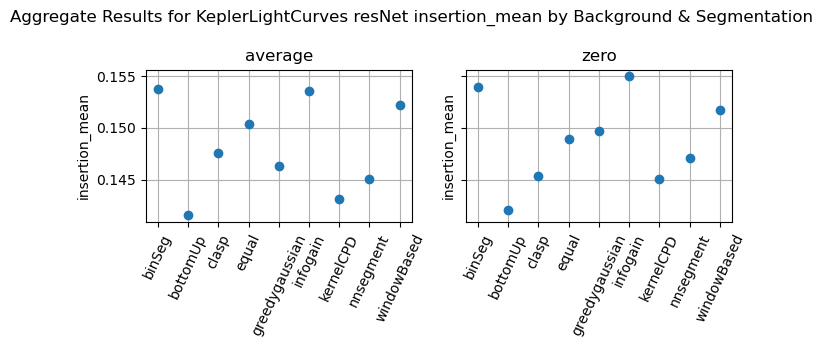

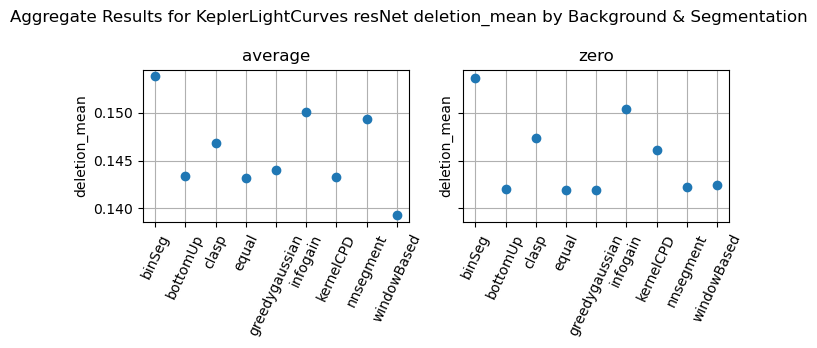

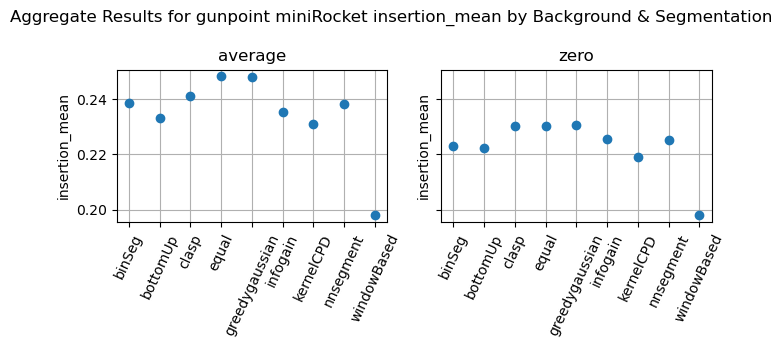

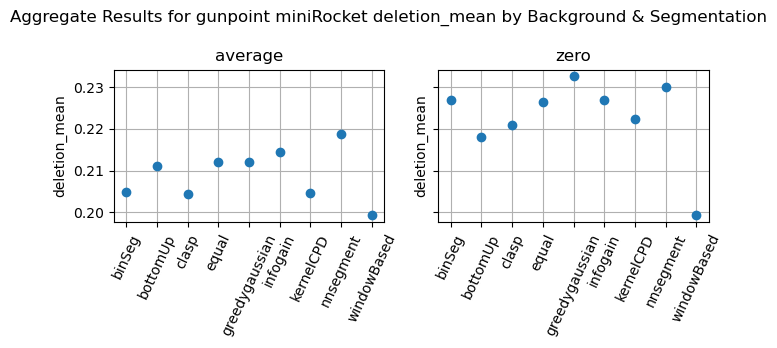

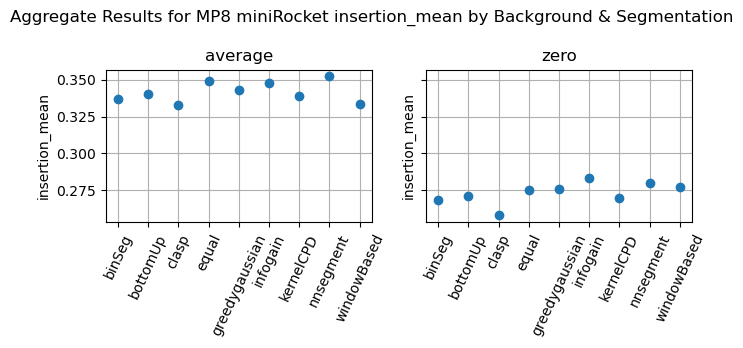

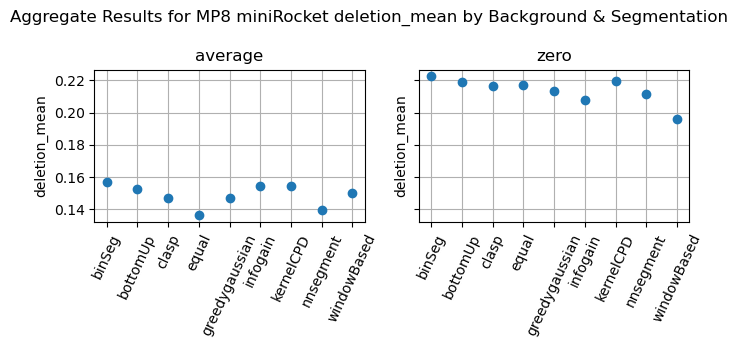

In [48]:


active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Dataset")
active_columns.remove("ML model")
active_columns.remove("Perturb")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_name = "AUC_difference"
perturb_names = ["insertion_mean", "deletion_mean"]

for pair_of_interest in pairs_of_interest:
    dataset_name, ml_model_name = pair_of_interest

    for perturb_name in perturb_names:

        mask = (df["Metric"]==metric_name) & (df["Perturb"]==perturb_name) & (df["Normalization"]=="default") & (df["Dataset"]==dataset_name) & (df["ML model"]==ml_model_name)
        df2 = df.loc[mask] # , ['Perturb', "Result"]
            # col_unique_lengths = []
            # for col in df2[active_columns]:
            #     col_unique_lengths.append(len(df2[col].unique()))
            # n_rows = len(active_combinations)
            # max_cols = np.max(col_unique_lengths)

        for column_names in active_combinations:
            column_names = column_names[::-1]
            df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
            index_levels = df3.index.levels
            df3.columns = df3.columns.get_level_values(1)
            df3 = df3.reset_index()
            # print(dataset_name, ml_model_name, metric_name, column_names[0], column_names[1])
            # print(index_levels)

            n_cols = len(index_levels[0])

            fig, ax = plt.subplots(1, n_cols, figsize = (3.5*n_cols, 3.5), sharex=True, sharey=True) #dpi

            for j, column_name in enumerate(index_levels[0]):
                mask4 = df3[column_names[0]]==column_name
                df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
                df4 = df4.set_index(column_names[1])

                df4_mean = df4["mean"]
                df4_std = df4["std"]
                
                ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
                ax[j].grid()
                ax[j].tick_params("x", rotation=65)
                ax[j].set_title(column_name)
                ax[j].set_ylabel(perturb_name)

                fig_name = f"Aggregate Results for {dataset_name} {ml_model_name} {perturb_name} by {column_names[0]} & {column_names[1]}"
                fig.suptitle(fig_name)
                fig.tight_layout()
                fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100

In [90]:
df2

Empty DataFrame
Columns: [Dataset, Segmentation, ML model, Background, Normalization, Perturb, Metric, Result]
Index: []

In [87]:
df2

Dataset Segmentation    ML model Background Normalization  \
4424     MP8     bottomUp  miniRocket    average       default   
4426     MP8     bottomUp  miniRocket    average       default   
4428     MP8     bottomUp  miniRocket    average       default   
4430     MP8     bottomUp  miniRocket    average       default   
4440     MP8     bottomUp  miniRocket       zero       default   
...      ...          ...         ...        ...           ...   
4762     MP8    nnsegment  miniRocket       zero       default   
4764     MP8    nnsegment  miniRocket       zero       default   
4766     MP8    nnsegment  miniRocket       zero       default   
4768     MP8    nnsegment  miniRocket       zero       default   
4770     MP8    nnsegment  miniRocket       zero       default   

                  Perturb     Metric    Result  
4424  normal_distribution  AUCSE_top  0.471339  
4426          global_mean  AUCSE_top  0.452496  
4428           local_mean  AUCSE_top  0.641287  
4430      global_gaussian  AUCSE_top  0.580005  
4440  normal_distribution  AUCSE_top  0.629915  
...                   ...        ...       ...  
4762                zeros  AUCSE_top  0.643762  
4764          global_mean  AUCSE_top  0.643762  
4766           local_mean  AUCSE_top  0.324238  
4768      global_gaussian  AUCSE_top  0.511740  
4770       local_gaussian  AUCSE_top  0.498819  

[92 rows x 8 columns]

In [ ]:
0/0

ZeroDivisionError: division by zero

In [1]:
import numpy as np
from sktime.annotation.igts import InformationGainSegmentation
from sklearn.preprocessing import MinMaxScaler 
from sktime.annotation.ggs import GreedyGaussianSegmentation
from sklearn.preprocessing import StandardScaler

In [10]:
def labels_to_changepoints(labels):
    labels = np.array(labels, dtype=int)
    keys = (labels[:-1] != labels[1:])
    change_points = np.append(0, np.arange(1, len(labels))[keys])
    return change_points

def get_GreedyGaussian_segmentation(X, n_segments=5, **kwargs):
    n_change_points = n_segments - 1
    n_channels, n_timepoints = X.shape[-2:]
    ggs = GreedyGaussianSegmentation(k_max=n_change_points, **kwargs) 
    X = X.T
    X_scaled = StandardScaler().fit_transform(X) 
    segmentation_labels = ggs.fit_predict(X_scaled) 
    change_points = labels_to_changepoints(segmentation_labels)
    change_points_per_channel = np.tile(change_points, (n_channels, 1))
    change_points_per_channel = np.fromiter(change_points_per_channel, dtype=object)
    return change_points_per_channel

In [13]:
a = np.random.rand(3, 10)
get_GreedyGaussian_segmentation(a)

array([array([0, 3, 6, 8]), array([0, 3, 6, 8]), array([0, 3, 6, 8])],
      dtype=object)

In [14]:
a = np.random.rand(3, 10)
get_GreedyGaussian_segmentation(a)

array([array([0, 4, 8]), array([0, 4, 8]), array([0, 4, 8])], dtype=object)

In [ ]:
0/0

### F_score
#### local_gaussian vs global_gaussian

### Per Column values correlations

In [ ]:
import seaborn as sns

In [ ]:
palette = sns.color_palette("tab10") # hls

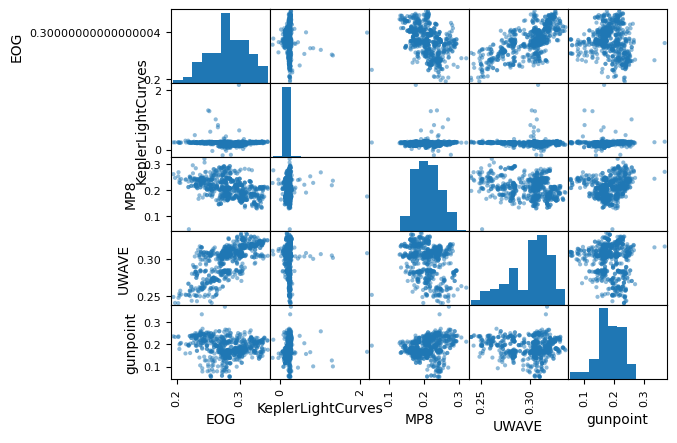

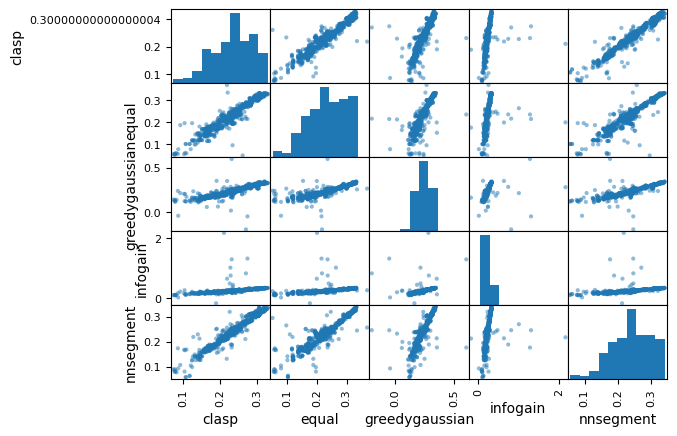

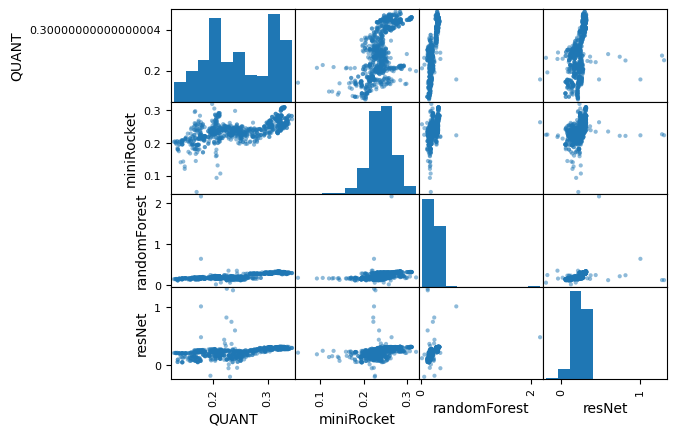

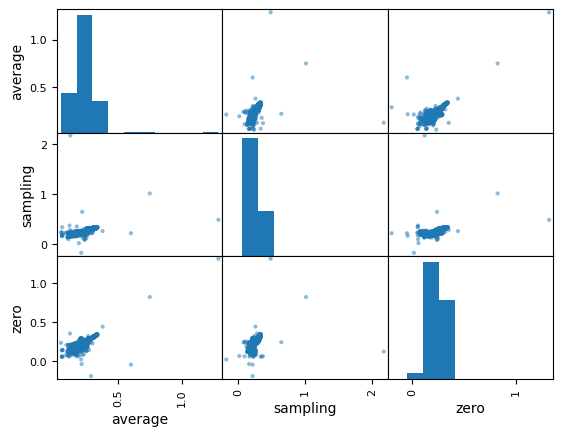

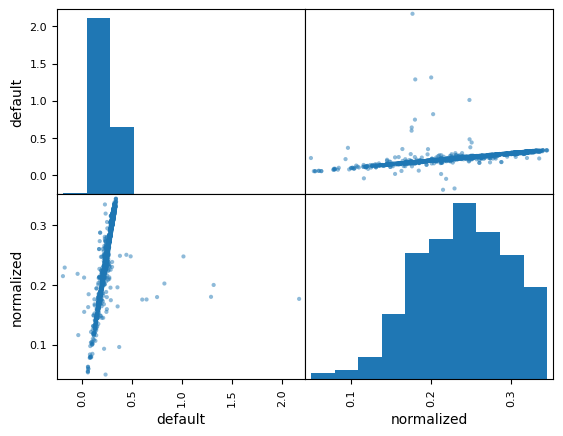

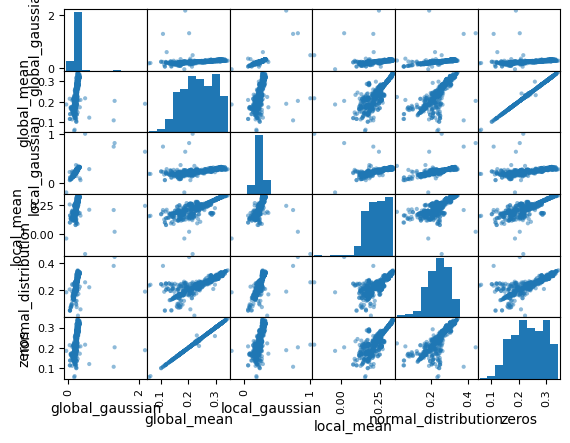

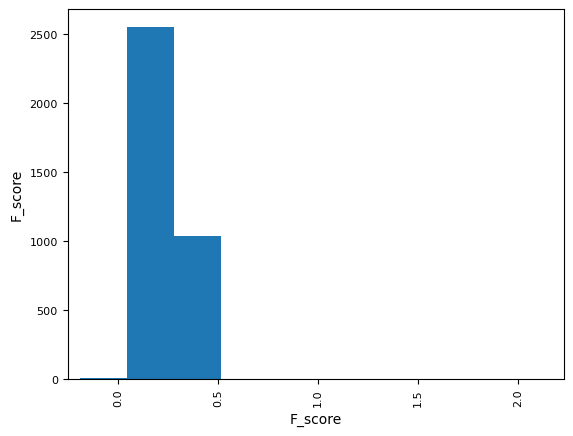

In [ ]:
metric_name = 'F_score'

mask = (df["Metric"]==metric_name)
df2 = df.loc[mask] # , ['Perturb', "Result"]

#fig, ax = plt.subplots(1, len(columns_wo_result), figsize = (25,4), sharex=False, sharey=True)

for i, column_name in enumerate(columns_wo_result):
    new_index = columns_wo_result[:]
    new_index.remove(column_name)
    df3 = df2.pivot(index = new_index, columns=column_name, values="Result")
    pd.plotting.scatter_matrix(df3)
    #ax[i].scattermatrix(df3.index, df3)
    # ax[i].set_xticklabels(df3.index, rotation=90)
    # ax[i].set_title(column_name)

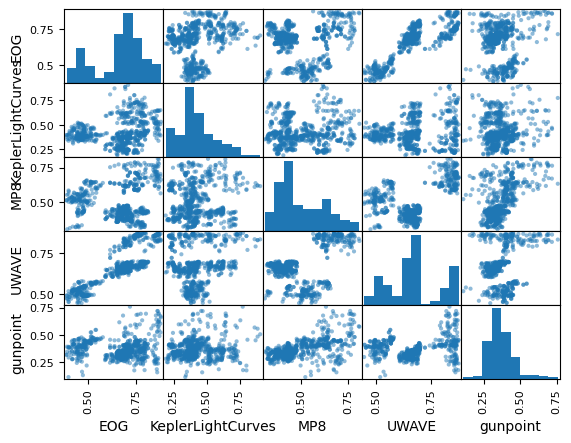

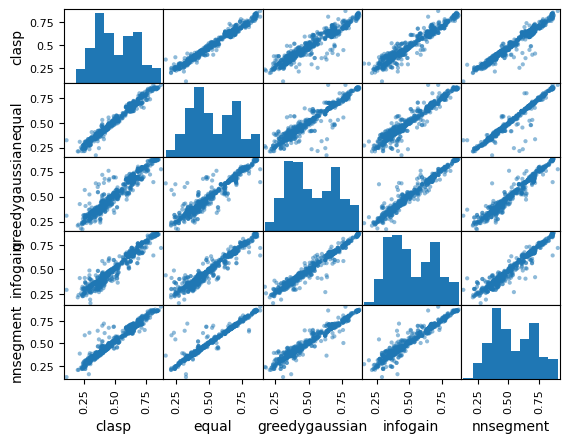

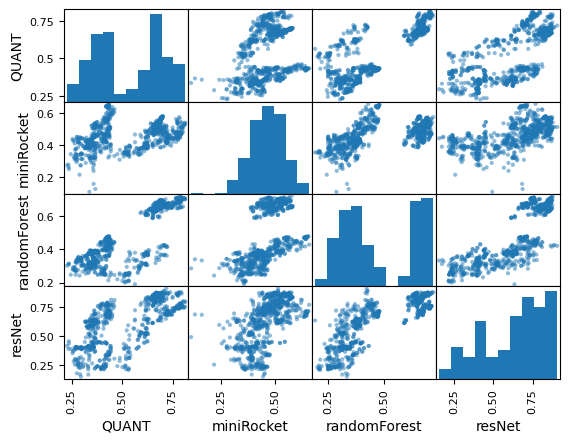

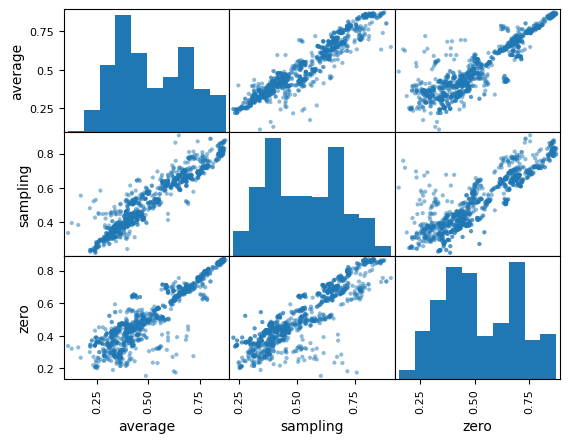

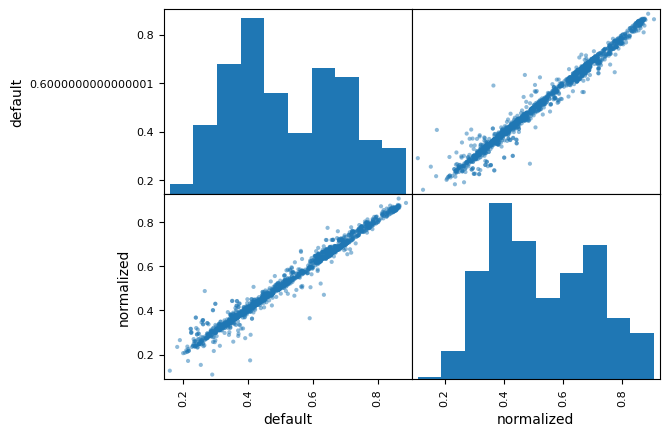

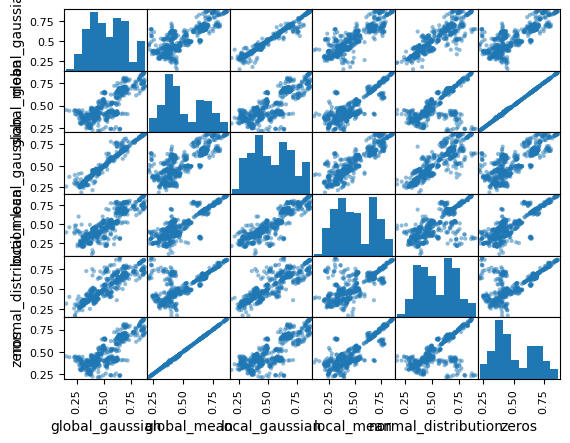

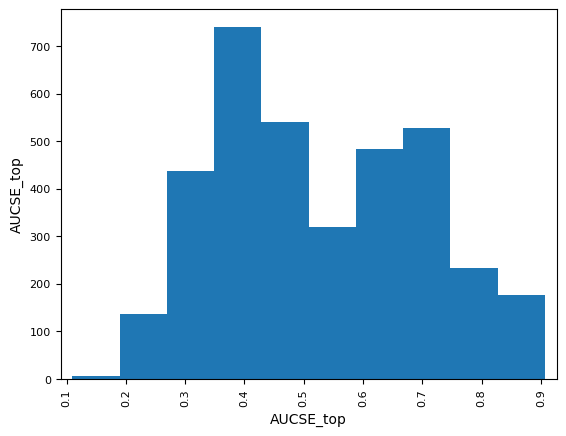

In [ ]:
metric_name = 'AUCSE_top'

mask = (df["Metric"]==metric_name)
df2 = df.loc[mask] # , ['Perturb', "Result"]

#fig, ax = plt.subplots(1, len(columns_wo_result), figsize = (25,4), sharex=False, sharey=True)

for i, column_name in enumerate(columns_wo_result):
    new_index = columns_wo_result[:]
    new_index.remove(column_name)
    df3 = df2.pivot(index = new_index, columns=column_name, values="Result")
    pd.plotting.scatter_matrix(df3)
    #ax[i].scattermatrix(df3.index, df3)
    # ax[i].set_xticklabels(df3.index, rotation=90)
    # ax[i].set_title(column_name)

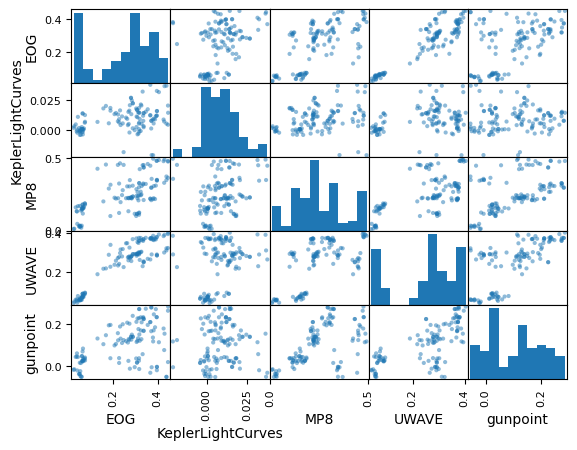

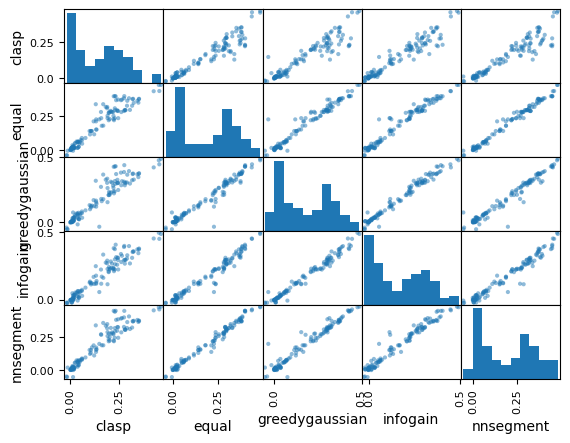

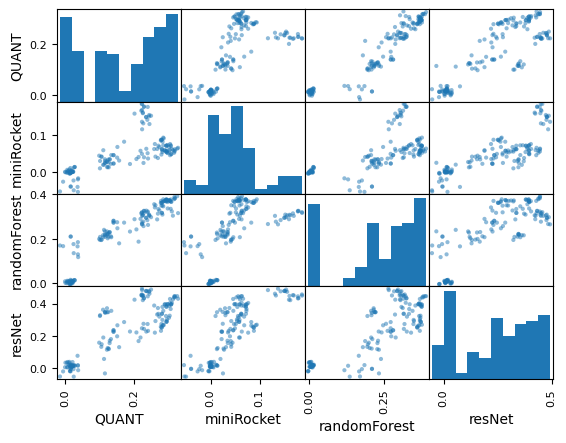

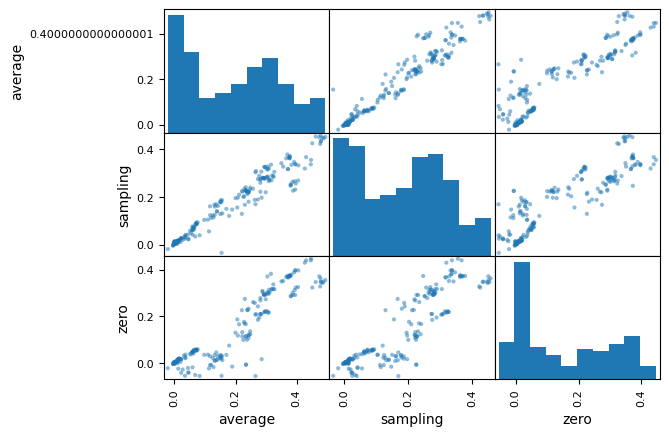

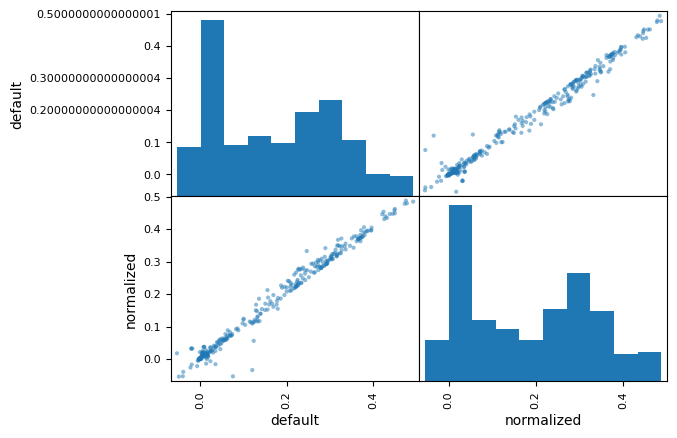

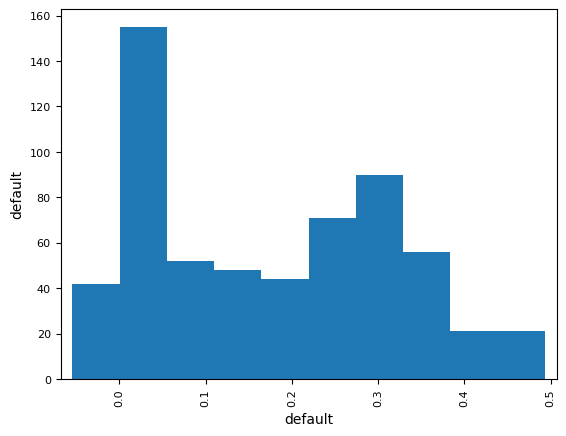

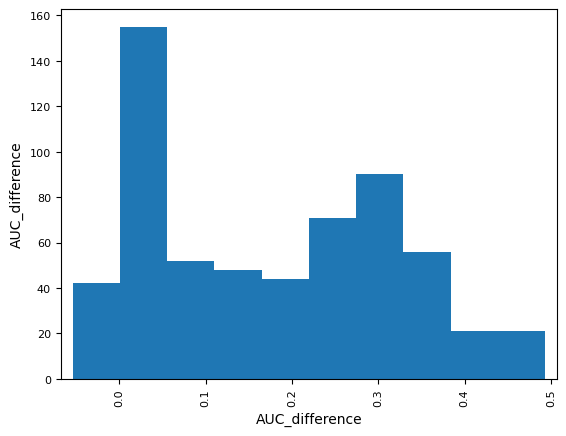

In [ ]:
metric_name = 'AUC_difference'

mask = (df["Metric"]==metric_name)
df2 = df.loc[mask] # , ['Perturb', "Result"]

#fig, ax = plt.subplots(1, len(columns_wo_result), figsize = (25,4), sharex=False, sharey=True)

for i, column_name in enumerate(columns_wo_result):
    new_index = columns_wo_result[:]
    new_index.remove(column_name)
    df3 = df2.pivot(index = new_index, columns=column_name, values="Result")
    pd.plotting.scatter_matrix(df3)
    #ax[i].scattermatrix(df3.index, df3)
    # ax[i].set_xticklabels(df3.index, rotation=90)
    # ax[i].set_title(column_name)

In [ ]:
df2 = df.unstack(["Background"])
df2.columns = df2.columns.droplevel(0)
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

c:\Users\Nikos\miniconda3\envs\segment_shap\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<Axes: xlabel='average', ylabel='sampling'>

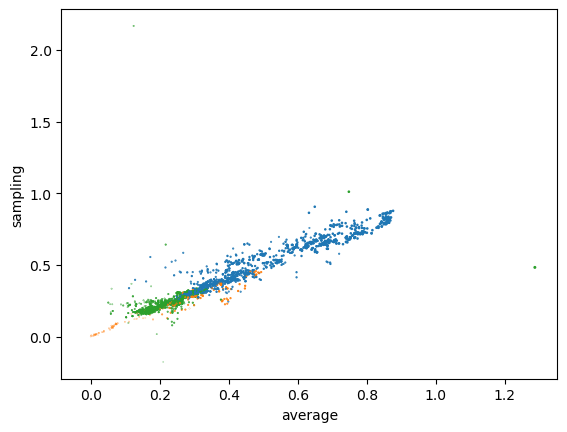

In [ ]:
color_index = np.unique(df2.index.get_level_values(-1), return_inverse=True)[1]
colors = np.array(palette)[color_index]
df2.plot.scatter(*df2.columns.values, c=colors)

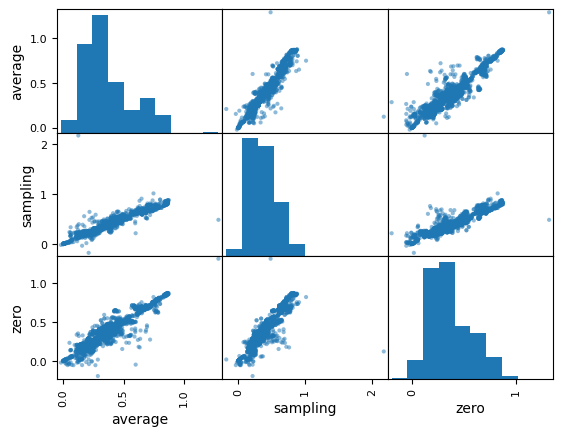

In [ ]:
pd.plotting.scatter_matrix(df2)
pass

In [ ]:
df2 = df.unstack(["Segmentation"])
df2.columns = df2.columns.droplevel(0)
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

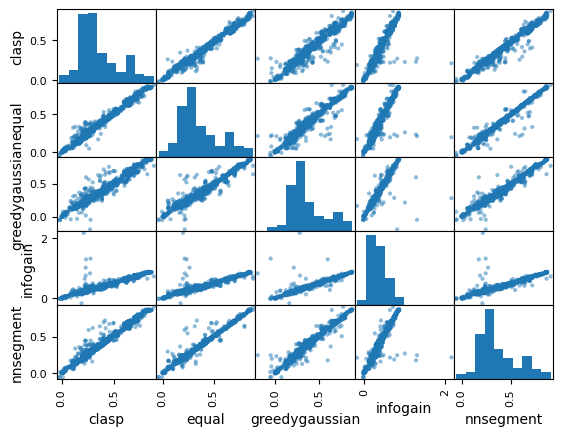

In [ ]:
pd.plotting.scatter_matrix(df2)
pass

In [ ]:
0/0

ZeroDivisionError: division by zero

In [ ]:
df2

Metric                                                              AUCSE_top  \
Perturb                                                   normal_distribution   
Dataset  Segmentation ML model   Background Normalization                       
UWAVE    clasp        miniRocket average    default                  0.538427   
                                            normalized               0.534783   
                                 sampling   default                  0.612026   
                                            normalized               0.669789   
                                 zero       default                  0.539440   
...                                                                       ...   
gunpoint nnsegment    resNet     average    normalized               0.493474   
                                 sampling   default                  0.487042   
                                            normalized               0.493356   
                                 zero       default                  0.485419   
                                            normalized               0.490639   

Metric                                                                F_score  \
Perturb                                                   normal_distribution   
Dataset  Segmentation ML model   Background Normalization                       
UWAVE    clasp        miniRocket average    default                  0.259149   
                                            normalized               0.257324   
                                 sampling   default                  0.299846   
                                            normalized               0.322807   
                                 zero       default                  0.261899   
...                                                                       ...   
gunpoint nnsegment    resNet     average    normalized               0.197166   
                                 sampling   default                  0.206901   
                                            normalized               0.210886   
                                 zero       default                  0.198961   
                                            normalized               0.202388   

Metric                                                    AUCSE_top   F_score  \
Perturb                                                       zeros     zeros   
Dataset  Segmentation ML model   Background Normalization                       
UWAVE    clasp        miniRocket average    default        0.660287  0.288037   
                                            normalized     0.678078  0.292222   
                                 sampling   default        0.648093  0.283887   
                                            normalized     0.673980  0.292719   
                                 zero       default        0.720051  0.297354   
...                                                             ...       ...   
gunpoint nnsegment    resNet     average    normalized     0.615215  0.213033   
                                 sampling   default        0.504398  0.232070   
                                            normalized     0.528187  0.232014   
                                 zero       default        0.753633  0.254793   
                                            normalized     0.764739  0.259414   

Metric                                                      AUCSE_top  \
Perturb                                                   global_mean   
Dataset  Segmentation ML model   Background Normalization               
UWAVE    clasp        miniRocket average    default          0.659023   
                                            normalized       0.676209   
                                 sampling   default          0.648215   
                                            normalized       0.672996   
                                 zero       default          0.720051   
...        

In [ ]:
vals = df2.groupby(level=("Dataset")).mean().values

In [ ]:
vals

array([[0.6855324 , 0.28057011, 0.71828536, 0.2958138 , 0.71828022,
        0.29582941, 0.70924087, 0.29813861, 0.68613147, 0.28058454,
        0.68468829, 0.28105192],
       [0.36098013, 0.16558069, 0.3586987 , 0.16028276, 0.3586987 ,
        0.16028276, 0.3566728 , 0.1612429 , 0.36523113, 0.13353505,
        0.34681318, 0.15673057]])

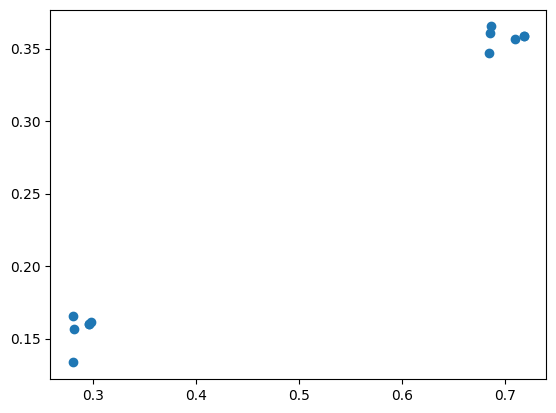

In [ ]:
plt.scatter(*vals)

In [ ]:
df2["F_score"].groupby(level=("Dataset", 'Segmentation')).mean()

Perturb                  normal_distribution     zeros  global_mean  \
Dataset  Segmentation                                                 
UWAVE    clasp                      0.274687  0.288673     0.288690   
         equal                      0.282539  0.299336     0.299356   
         greedygaussian             0.283751  0.298759     0.298770   
         infogain                   0.280672  0.293619     0.293635   
         nnsegment                  0.281202  0.298683     0.298696   
gunpoint clasp                      0.161752  0.160789     0.160789   
         equal                      0.148711  0.153905     0.153905   
         greedygaussian             0.171350  0.163258     0.163258   
         infogain                   0.176317  0.156651     0.156651   
         nnsegment                  0.169772  0.166811     0.166811   

Perturb                  local_mean  global_gaussian  local_gaussian  
Dataset  Segmentation                                                 
UWAVE    clasp             0.290478         0.274625        0.275029  
         equal             0.302188         0.282444        0.283118  
         greedygaussian    0.301157         0.283842        0.284356  
         infogain          0.295905         0.280646        0.281294  
         nnsegment         0.300965         0.281365        0.281462  
gunpoint clasp             0.152200         0.161012        0.145715  
         equal             0.150435         0.148643        0.143215  
         greedygaussian    0.166813         0.171361        0.159863  
         infogain          0.165410         0.016511        0.173378  
         nnsegment         0.171356         0.170148        0.161482

In [ ]:
df2.groupby(level=("Dataset")).mean()

Perturb  normal_distribution               zeros           global_mean  \
Metric             AUCSE_top   F_score AUCSE_top   F_score   AUCSE_top   
Dataset                                                                  
UWAVE               0.685532  0.280570  0.718285  0.295814    0.718280   
gunpoint            0.360980  0.165581  0.358699  0.160283    0.358699   

Perturb            local_mean           global_gaussian            \
Metric     F_score  AUCSE_top   F_score       AUCSE_top   F_score   
Dataset                                                             
UWAVE     0.295829   0.709241  0.298139        0.686131  0.280585   
gunpoint  0.160283   0.356673  0.161243        0.365231  0.133535   

Perturb  local_gaussian            
Metric        AUCSE_top   F_score  
Dataset                            
UWAVE          0.684688  0.281052  
gunpoint       0.346813  0.156731

In [ ]:
df2.groupby(level=('Segmentation')).mean()

Perturb        normal_distribution               zeros           global_mean  \
Metric                   AUCSE_top   F_score AUCSE_top   F_score   AUCSE_top   
Segmentation                                                                   
clasp                     0.503013  0.218219  0.521946  0.224731    0.521945   
equal                     0.533172  0.215625  0.550048  0.226620    0.550051   
greedygaussian            0.535196  0.227551  0.542901  0.231008    0.542892   
infogain                  0.516158  0.228495  0.529818  0.225135    0.529817   
nnsegment                 0.528743  0.225487  0.547747  0.232747    0.547743   

Perturb                  local_mean           global_gaussian            \
Metric           F_score  AUCSE_top   F_score       AUCSE_top   F_score   
Segmentation                                                              
clasp           0.224739   0.505324  0.221339        0.506134  0.217819   
equal           0.226631   0.540018  0.226311        0.533175  0.215544   
greedygaussian  0.231014   0.541474  0.233985        0.540443  0.227602   
infogain        0.225143   0.528180  0.230657        0.517239  0.148578   
nnsegment       0.232754   0.549789  0.236161        0.531415  0.225757   

Perturb        local_gaussian            
Metric              AUCSE_top   F_score  
Segmentation                             
clasp                0.495415  0.210372  
equal                0.524497  0.213166  
greedygaussian       0.520534  0.222110  
infogain             0.513947  0.227336  
nnsegment            0.524361  0.221472

In [ ]:
df2.groupby(level=("ML model")).mean()

Perturb      normal_distribution               zeros           global_mean  \
Metric                 AUCSE_top   F_score AUCSE_top   F_score   AUCSE_top   
ML model                                                                     
miniRocket              0.471642  0.209057  0.476258  0.207937    0.476250   
randomForest            0.484716  0.228739  0.509178  0.241806    0.509178   
resNet                  0.613411  0.231430  0.630040  0.234402    0.630040   

Perturb                local_mean           global_gaussian            \
Metric         F_score  AUCSE_top   F_score       AUCSE_top   F_score   
ML model                                                                
miniRocket    0.207960   0.465192  0.209240        0.472131  0.161151   
randomForest  0.241806   0.491761  0.236569        0.483761  0.228632   
resNet        0.234402   0.641918  0.243263        0.621152  0.231396   

Perturb      local_gaussian            
Metric            AUCSE_top   F_score  
ML model                               
miniRocket         0.443839  0.197479  
randomForest       0.469916  0.223540  
resNet             0.633496  0.235655

In [ ]:
df2.groupby(level=("Background")).mean()

Perturb    normal_distribution               zeros           global_mean  \
Metric               AUCSE_top   F_score AUCSE_top   F_score   AUCSE_top   
Background                                                                 
average               0.475765  0.198182  0.498045  0.203332    0.498053   
sampling              0.545851  0.245845  0.516964  0.237249    0.516956   
zero                  0.548153  0.225199  0.600467  0.243564    0.600460   

Perturb              local_mean           global_gaussian            \
Metric       F_score  AUCSE_top   F_score       AUCSE_top   F_score   
Background                                                            
average     0.203341   0.592623  0.240304        0.481797  0.150370   
sampling    0.237254   0.520034  0.243762        0.548044  0.246446   
zero        0.243572   0.486214  0.205006        0.547202  0.224364   

Perturb    local_gaussian            
Metric          AUCSE_top   F_score  
Background                           
average          0.490520  0.203760  
sampling         0.546220  0.247256  
zero             0.510512  0.205657